In [1]:
import os
import cv2
import json
import random
import numpy as np
import sys
import skimage
import itertools
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from itertools import chain
import tarfile
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LocallyConnected2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.io import loadmat
from tensorflow.keras.optimizers import Adam, RMSprop
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
import seaborn as sns
from sklearn.utils import shuffle
from PIL import Image, ImageDraw
from skimage.transform import resize
from skimage.io import imsave, imread
from os import makedirs, listdir
from shutil import copyfile, rmtree
from skimage import img_as_uint, img_as_ubyte, img_as_float
from skimage.exposure import is_low_contrast
from skimage.transform import warp, AffineTransform, ProjectiveTransform
from itertools import tee  
from sklearn import metrics as sk_metrics
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import multilabel_confusion_matrix
import h5py
TRAIN_32_x_32_PATH="data/train_32x32.mat"
TEST_32_x_32_PATH="data/test_32x32.mat"
EXTRA_32_x_32_PATH="data/extra_32x32.mat"
MNIST_GENERATED_PATH="data/mnist"
SVHN_SINGLE_PATH="data/mnist_single"
SVHN_IMAGES_PATH="data/svhn"
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def extract_tarball(filename, path, force=False):
    if (filename.endswith("tar.gz")):
        tar = tarfile.open(filename, "r:gz")
        tar.extractall(path)
        tar.close()

In [4]:
%mkdir data
%mkdir data/mnist
%mkdir data/mnist/test
%mkdir data/mnist/train
%mkdir data/model_weights
%mkdir data/svhn
%mkdir data/mnist_single
%mkdir data/mnist_single/train
%mkdir data/mnist_single/test
!wget -O "data/train_32x32.mat" "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
!wget -O "data/test_32x32.mat" "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"
!wget -O "data/extra_32x32.mat" "http://ufldl.stanford.edu/housenumbers/extra_32x32.mat"
!wget -O "data/train.tar.gz" "http://ufldl.stanford.edu/housenumbers/train.tar.gz"
!wget -O "data/test.tar.gz" "http://ufldl.stanford.edu/housenumbers/test.tar.gz"
!wget -O "data/extra.tar.gz" "http://ufldl.stanford.edu/housenumbers/extra.tar.gz"
extract_tarball("data/train.tar.gz", SVHN_IMAGES_PATH)
extract_tarball("data/test.tar.gz", SVHN_IMAGES_PATH)
extract_tarball("data/extra.tar.gz", SVHN_IMAGES_PATH)
%rm "data/train.tar.gz"
%rm "data/test.tar.gz"
%rm "data/extra.tar.gz"

--2020-05-30 05:47:27--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘data/train_32x32.mat’

data/train_32x32.ma 100%[===================>] 173.61M  18.6MB/s    in 13s     

2020-05-30 05:47:40 (13.6 MB/s) - ‘data/train_32x32.mat’ saved [182040794/182040794]

--2020-05-30 05:47:50--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘data/test_32x32.mat’

data/test_32x32.mat 100%[===================>]  61.30M  16.9MB/s    in 6.2s    

2020-05-30 05:47:57 (9.95 MB/s) - ‘data/test_32x32.mat

In [0]:
def plot_loss_history(history):
    plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()

In [0]:
def plot_history(history):
    plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
    plt.subplot(211)
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.subplot(212)
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()

In [0]:
def plot_metrics(metrics_callback):
    plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
    plt.title(f'{metrics_callback.dataset_type} metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metric value')
    plt.plot(metrics_callback.f1_scores, label='F1')
    plt.plot(metrics_callback.recalls, label='Recall')
    plt.plot(metrics_callback.accuracies, label='Accuracy')
    plt.legend()
    plt.show()

In [0]:
def x_y_from_dataframe(df, image_size, x_column, y_column):
    images=np.full((df.shape[0],*image_size), 0)
    y=[]
    for idx,(index, img_info) in enumerate(list(df.iterrows())):
        image_data = imread(img_info[x_column])
        images[idx]=image_data
        y.append(img_info[y_column])
    return images, np.array(y)

In [0]:
def plot_images(images, labels, nrows, ncols, labels_pred=None, random_choice=True):
    def get_title(labels, labels_pred=None, i=None):
        if i is None:
            label=labels
            if labels_pred is not None:
                label_pred=labels_pred
        else:
            label=labels[i]
            if labels_pred is not None:
                label_pred=labels_pred[i]
        if labels_pred is None:
            return f"Actual: {label}"
        else:
            return f"Pred: {label_pred}\n Actual: {label}"
    if nrows==1 and ncols==1:
        plt.imshow(images, cmap='gray')
        plt.axis("off")
        plt.title(get_title(labels=labels, labels_pred=labels_pred))
    else:
        if random_choice:
            idxes=random.sample(range(images.shape[0]), k=nrows*ncols)
            img_sample=images[idxes]
            labels_sample=labels[idxes]
            if labels_pred is not None:
                labels_pred_sample=labels_pred[idxes]
            else:
                labels_pred_sample=None
        else:
            img_sample=images[:nrow*ncols]
            labels_sample=labels[:nrow*ncols]
            if labels_pred is not None:
                labels_pred_sample=labels_pred[:nrow*ncols]
            else:
                labels_pred_sample=None
        fig, axes = plt.subplots(nrows, ncols, figsize=(12, 8))
        for i, ax in enumerate(axes.flat): 
            if len(img_sample[i].shape) == 3 and img_sample[i].shape[2]==3:
                ax.imshow(img_sample[i])
            else:
                if len(img_sample[i].shape)==2:
                    ax.imshow(img_sample[i], cmap='gray')
                else:
                    ax.imshow(img_sample[i].reshape(img_sample[i].shape[:2]), cmap='gray')
            ax.axis("off")
            ax.set_title(get_title(labels=labels_sample, labels_pred=labels_pred_sample, i=i))
        plt.tight_layout()

In [0]:
def plot_digits_distribution(y, dataset_type):
    if isinstance(y, list):
        all_labels = list(chain.from_iterable(y))
    else:
        all_labels=y
    labels_count = Counter(all_labels)
    ax = sns.countplot(all_labels, order=[k for k, _ in labels_count.most_common()])
    ax.set_title(f'Number of images per class in {dataset_type}')
    ax.set_ylim(1, max(labels_count.values())*1.2)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [0]:
def plot_number_length_distribution(y, dataset_type):
    labels_length = [len(lbs) for lbs in y]
    labels_count = Counter(labels_length)
    ax = sns.countplot(labels_length, order=[k for k, _ in labels_count.most_common()])
    ax.set_title(f'Number of digits in image in {dataset_type}')
    ax.set_ylim(1, max(labels_count.values())*1.2)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [0]:
class DigitStructWrapper:
    """
    Wrapper for the H5PY digitStruct files from the SVHN dataset

    Creates an array of dictionaries containing the filename and bounding boxes for every digit in the image.

    Adapted from https://github.com/hangyao
    """

    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

    def get_name(self, n):
        """Return the name of the n(th) digit struct"""
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]][()]])

    def get_attribute(self, attr):
        """Helper function for dealing with one vs. multiple bounding boxes"""
        if (len(attr) > 1):
            attr = [self.inf[attr[()][j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr[()][0][0]]
        return attr

    def get_bbox(self, n):
        """Return a dict containing the data from the n(th) bbox"""
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.get_attribute(self.inf[bb]["height"])
        bbox['label'] = self.get_attribute(self.inf[bb]["label"])
        bbox['left'] = self.get_attribute(self.inf[bb]["left"])
        bbox['top'] = self.get_attribute(self.inf[bb]["top"])
        bbox['width'] = self.get_attribute(self.inf[bb]["width"])
        return bbox

    def get_item(self, n):
        """Return the name and bounding boxes of a single image"""
        s = self.get_bbox(n)
        s['name'] = self.get_name(n)
        return s

    def unpack(self):
        """Returns a list of dicts containing all the bounding boxes"""
        return [self.get_item(i) for i in range(len(self.digitStructName))]

    def unpack_all(self):
        pictDat = self.unpack()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = {'filename': pictDat[i]["name"]}
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label'] = pictDat[i]['label'][j]
                figure['left'] = pictDat[i]['left'][j]
                figure['top'] = pictDat[i]['top'][j]
                figure['width'] = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [0]:
class Metrics(Callback):
    def __init__(self, generator, steps=None, dataset_type="validation", threshold=0.5):
        self.generator = generator
        self.steps = steps or len(generator)
        self.dataset_type= dataset_type
        self.threshold = threshold

    def on_train_begin(self, logs={}):
        self.f1_scores = []
        self.recalls = []
        self.precisions = []
        self.accuracies = []
        self.hamming_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.generator.reset()
        gen_1, gen_2 = tee(self.generator)
        y_true = np.vstack(tuple(next(gen_1)[1] for _ in range(self.steps))).astype('int')
        y_pred = (self.model.predict(gen_2, steps=self.steps) > self.threshold).astype('int')
        f1 = sk_metrics.f1_score(y_true, y_pred, average='weighted')
        precision = sk_metrics.precision_score(y_true, y_pred, average='weighted')
        recall = sk_metrics.recall_score(y_true, y_pred, average='weighted')
        accuracy = sk_metrics.accuracy_score(y_true, y_pred)
        hamming_loss = sk_metrics.hamming_loss(y_true, y_pred)
        self.f1_scores.append(f1)
        self.recalls.append(recall)
        self.precisions.append(precision)
        self.accuracies.append(accuracy)
        self.hamming_losses.append(hamming_loss)
        print(f"{self.dataset_type} scores: F1-{f1:.3f} - Precision: {precision:.3f} - Recall: {recall:.3f}\nAccuracy: {accuracy:.3f} - Hamming loss {hamming_loss:.3f}")
        return f1, precision, recall, accuracy, hamming_loss

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

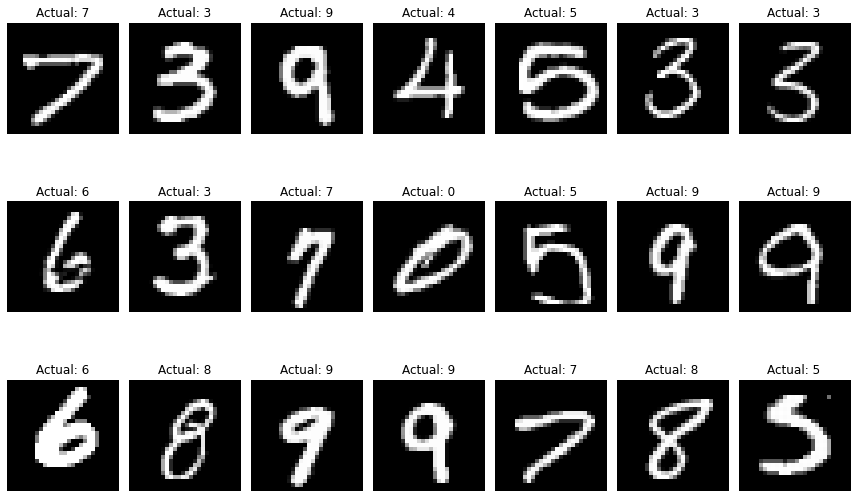

In [0]:
plot_images(X_train, y_train, 3, 7)

In [0]:
def concat_images(images, height=64, width=64, new_height=12, new_width=12):
    num_digits = len(images)    
    new_image = np.zeros(shape=(height, width), dtype="uint8")
    y_pad = (height - new_height) // 2
    x_pad = (width - num_digits * new_width) // 2
    for i in range(num_digits):
        scaled = resize(images[i], (new_height, new_width), preserve_range=True)
        x_offset = x_pad + (i*new_width)
        new_image[y_pad:height-y_pad, x_offset:x_offset+new_width] = scaled
    return new_image

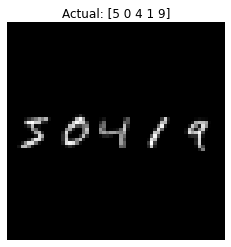

In [0]:
plot_images(concat_images(X_train[0:5]),y_train[:5], 1, 1)

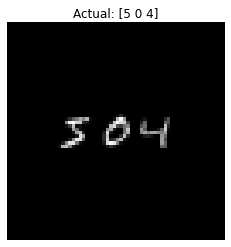

In [0]:
plot_images(concat_images(X_train[0:3]),y_train[:3], 1, 1)

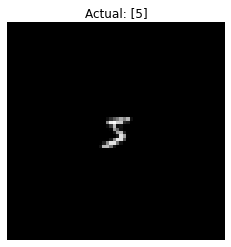

In [0]:
plot_images(concat_images(X_train[0:1]),y_train[:1], 1, 1)

In [0]:
train_size=150000
test_size=20000
def generate_digit_sequences(data, labels, generated_size, dataset_type, max_digits=5, height=64, width=64):
    mnist_df = pd.DataFrame(columns=["image_path", "labels"])
    last_idx=0
    splits=[2, 4, 8, 16, 32, 32]
    for i in range(1, max_digits+1):
        for j in range(generated_size//splits[max_digits-i]):
            selection = random.sample(range(0, data.shape[0]), i)
            image = concat_images(data[selection])
            path_to_image=f"{MNIST_GENERATED_PATH}/{dataset_type}/{last_idx}.png"
            imsave(path_to_image, img_as_ubyte(image), check_contrast=False)
            image_labels = labels[selection].astype('int')
            mnist_df.loc[last_idx] = [path_to_image, image_labels.tolist()]
            last_idx+=1
    return mnist_df
mnist_train_df=generate_digit_sequences(X_train, y_train, train_size, "train")
mnist_test_df=generate_digit_sequences(X_test, y_test, test_size, "test")
print(f"Training size: {mnist_train_df.shape}")
print(f"Test size: {mnist_test_df.shape}")

Training size: (145312, 2)
Test size: (19375, 2)


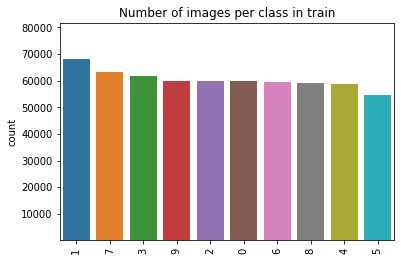

In [0]:
plot_digits_distribution(mnist_train_df['labels'].tolist(), "train")

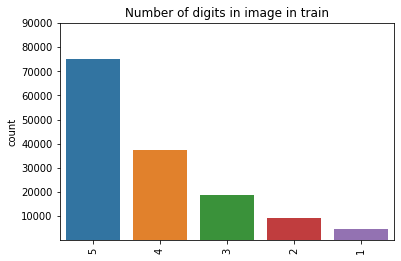

In [0]:
plot_number_length_distribution(mnist_train_df['labels'].tolist(), "train")

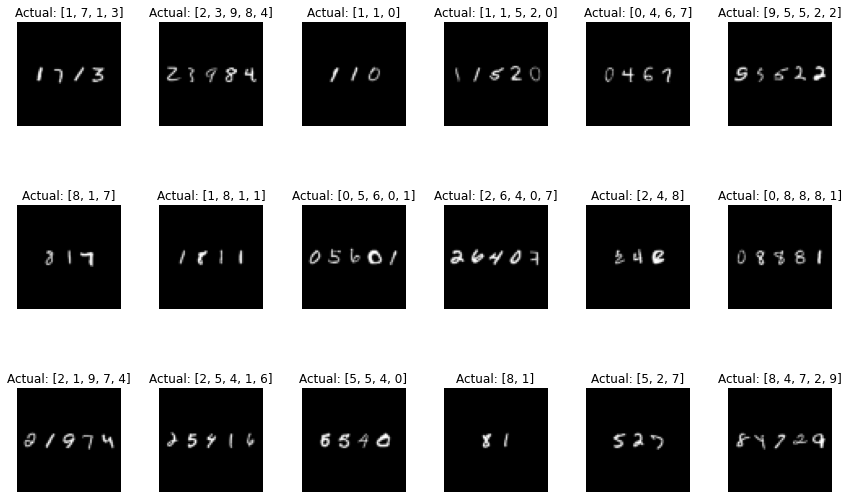

In [0]:
plot_images(*x_y_from_dataframe(mnist_train_df.sample(20), (64, 64), "image_path", "labels"), 3, 6)

In [0]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
train_iterator=train_datagen.flow_from_dataframe(
    mnist_train_df,
    x_col="image_path",
    y_col="labels",
    target_size=(64, 64),
    color_mode="grayscale",
    class_mode="categorical",
    classes=list(range(10)),
    shuffle=True,
    subset='training'
)
valid_iterator=train_datagen.flow_from_dataframe(
    mnist_train_df,
    x_col="image_path",
    y_col="labels",
    target_size=(64, 64),
    color_mode="grayscale",
    class_mode="categorical",
    classes=list(range(10)),
    shuffle=True,
    subset='validation'
)
test_iter=test_datagen.flow_from_dataframe(
    mnist_test_df,
    x_col="image_path",
    y_col="labels",
    target_size=(64, 64),
    class_mode="categorical",
    classes=list(range(10)),
    color_mode="grayscale",
    shuffle=False
)

Found 116250 validated image filenames belonging to 10 classes.
Found 29062 validated image filenames belonging to 10 classes.
Found 19375 validated image filenames belonging to 10 classes.


In [0]:
mnist_metrics_valid = Metrics(valid_iterator, dataset_type="Validation")
mnist_metrics_train = Metrics(train_iterator, dataset_type="Train")

In [0]:
chanDim = -1
model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5), activation='relu', padding='same',
                 input_shape=(64, 64, 1)))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model.add(Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(5,5), activation='relu', padding='same'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1))) 
model.add(Conv2D(64, kernel_size=(5,5), activation='relu', padding='same'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(5,5), activation='relu', padding='same'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1))) 
model.add(Conv2D(128, kernel_size=(5,5), activation='relu', padding='same'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2))) 
model.add(Dropout(0.25))
model.add(Conv2D(196, kernel_size=(5,5), activation='relu', padding='same'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1))) 
model.add(Conv2D(196, kernel_size=(5,5), activation='relu', padding='same'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2))) 
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 32)        832       
_________________________________________________________________
batch_normalization_8 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 63, 63, 32)        25632     
_________________________________________________________________
batch_normalization_9 (Batch (None, 63, 63, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 31, 31, 32)       

In [0]:
filepath="data/model_weights/weights-synthetic-mnist.hdf5"
callbacks=[
    EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True),
    ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
    mnist_metrics_train,
    mnist_metrics_valid
]
history= model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=50, verbose=1, validation_data=valid_iterator, validation_steps=len(valid_iterator), callbacks=callbacks)
loss, accuracy = model.evaluate(test_iter, steps=len(test_iter), verbose=1)

Epoch 1/50
3633/3633 [==============================] - ETA: 0s - loss: 0.1451 - accuracy: 0.4256
Epoch 00001: val_loss improved from inf to 0.71485, saving model to data/model_weights/weights-synthetic-mnist.hdf5
Train scores: F1-0.839 - Precision: 0.789 - Recall: 0.964
Accuracy: 0.101 - Hamming loss 0.185
Validation scores: F1-0.703 - Precision: 0.631 - Recall: 0.978
Accuracy: 0.001 - Hamming loss 0.320
3633/3633 [==============================] - 130s 36ms/step - loss: 0.1451 - accuracy: 0.4256 - val_loss: 0.7148 - val_accuracy: 0.4413
Epoch 2/50
3633/3633 [==============================] - ETA: 0s - loss: 0.0315 - accuracy: 0.3535
Epoch 00002: val_loss improved from 0.71485 to 0.01382, saving model to data/model_weights/weights-synthetic-mnist.hdf5
Train scores: F1-0.996 - Precision: 0.996 - Recall: 0.995
Accuracy: 0.973 - Hamming loss 0.003
Validation scores: F1-0.993 - Precision: 0.994 - Recall: 0.993
Accuracy: 0.979 - Hamming loss 0.003
3633/3633 [==============================]

Model loss=0.03813289478421211, accuracy=0.37538063526153564


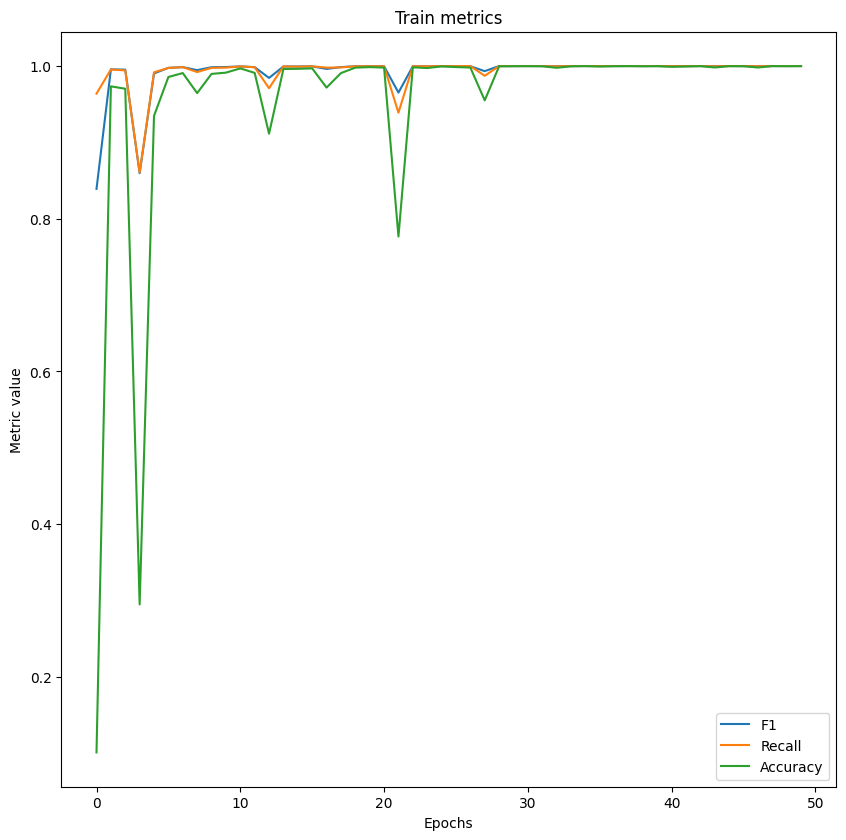

In [0]:
print(f"Model loss={loss}, accuracy={accuracy}")
plot_metrics(mnist_metrics_train)

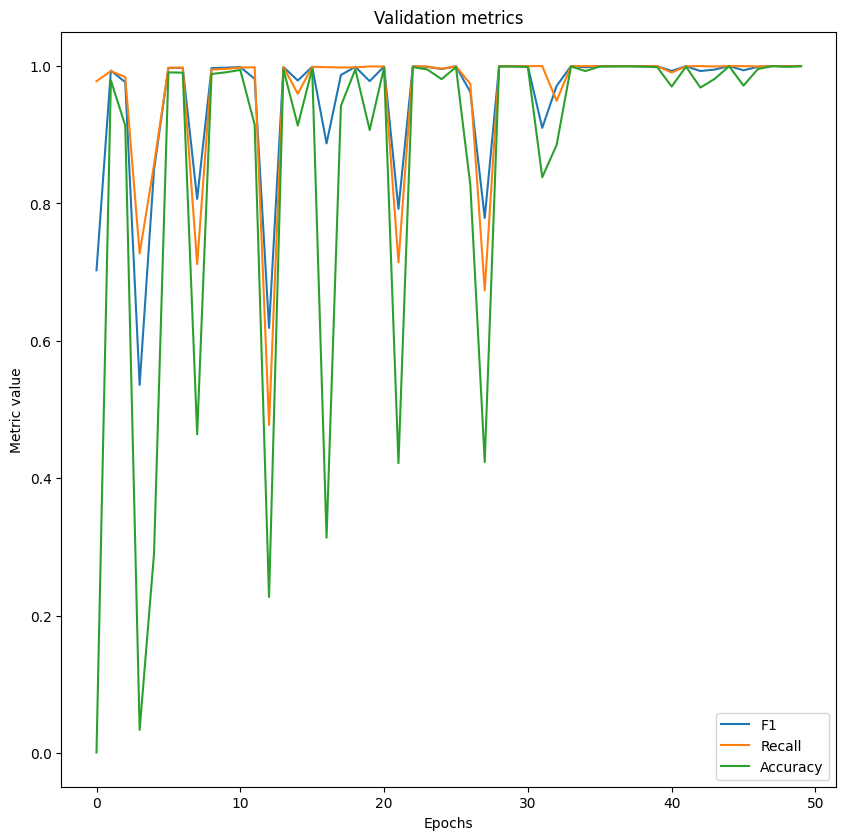

In [0]:
plot_metrics(mnist_metrics_valid)

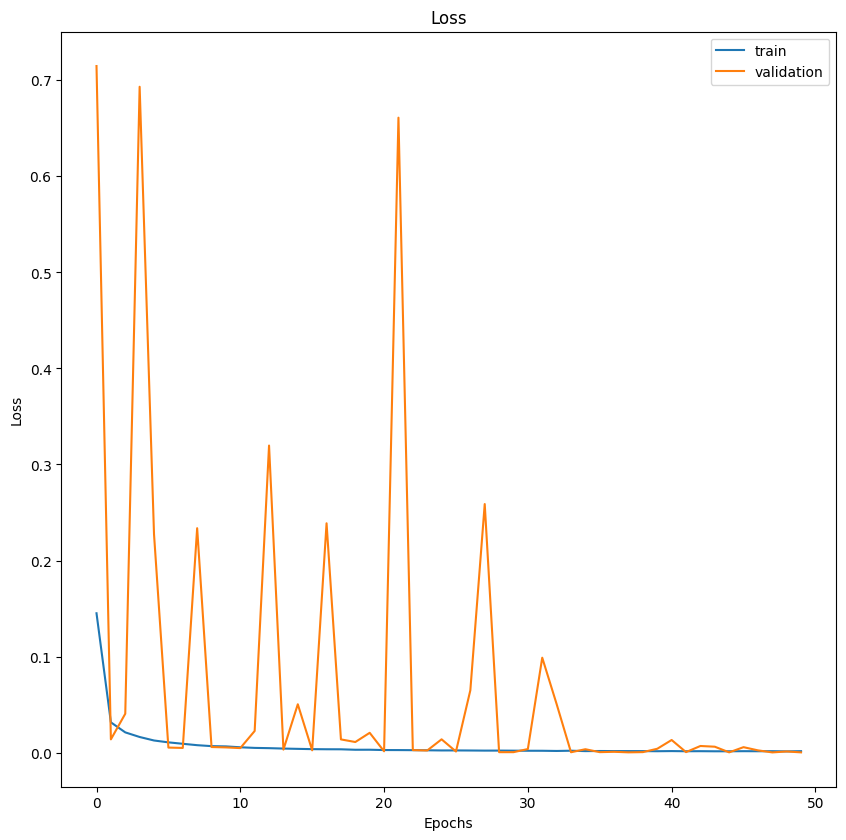

In [0]:
plot_loss_history(history)

In [0]:
test_iter.reset()
gen_1, gen_2 = tee(test_iter)
y_true = np.vstack(tuple(next(gen_1)[1] for _ in range(len(test_iter)))).astype('int')
y_pred = model.predict(gen_2, steps=len(test_iter))

In [0]:
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=y_pred.copy()
    pred[pred>=val]=1
    pred[pred<val]=0
    precision = sk_metrics.precision_score(y_true, pred, average='weighted')
    recall = sk_metrics.recall_score(y_true, pred, average='weighted')
    f1 = sk_metrics.f1_score(y_true, pred, average='weighted')
    accuracy = sk_metrics.accuracy_score(y_true, pred)
    print(f"Threshold: {val}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-measure: {f1:.4f}, Accuracy: {accuracy:.4f}")

Threshold: 0.1, Precision: 0.9926, Recall: 0.9938, F1-measure: 0.9932, Accuracy: 0.9664
Threshold: 0.2, Precision: 0.9930, Recall: 0.9934, F1-measure: 0.9932, Accuracy: 0.9665
Threshold: 0.3, Precision: 0.9931, Recall: 0.9932, F1-measure: 0.9931, Accuracy: 0.9663
Threshold: 0.4, Precision: 0.9933, Recall: 0.9929, F1-measure: 0.9931, Accuracy: 0.9661
Threshold: 0.5, Precision: 0.9935, Recall: 0.9928, F1-measure: 0.9931, Accuracy: 0.9661
Threshold: 0.6, Precision: 0.9937, Recall: 0.9926, F1-measure: 0.9931, Accuracy: 0.9658
Threshold: 0.7, Precision: 0.9938, Recall: 0.9923, F1-measure: 0.9931, Accuracy: 0.9655
Threshold: 0.8, Precision: 0.9942, Recall: 0.9920, F1-measure: 0.9931, Accuracy: 0.9652
Threshold: 0.9, Precision: 0.9948, Recall: 0.9917, F1-measure: 0.9933, Accuracy: 0.9652


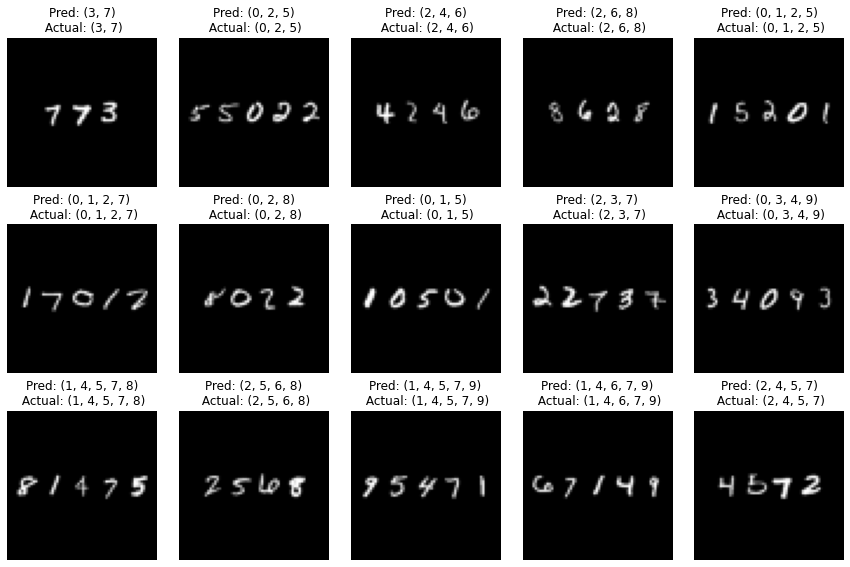

In [0]:
test_iter.reset()
ml_binalizer=MultiLabelBinarizer()
ml_binalizer.fit(mnist_test_df['labels'].tolist())
y_pred = (y_pred>=0.5).astype('int')
correct = (y_pred==y_true).all(axis=1)
all_images=np.vstack(tuple(next(test_iter)[0] for _ in range(len(test_iter))))
images = all_images[correct]
labels = ml_binalizer.inverse_transform(y_true[correct])
labels_pred = ml_binalizer.inverse_transform(y_pred[correct])
plot_images(images, np.array(labels), 3, 5, np.array(labels_pred))

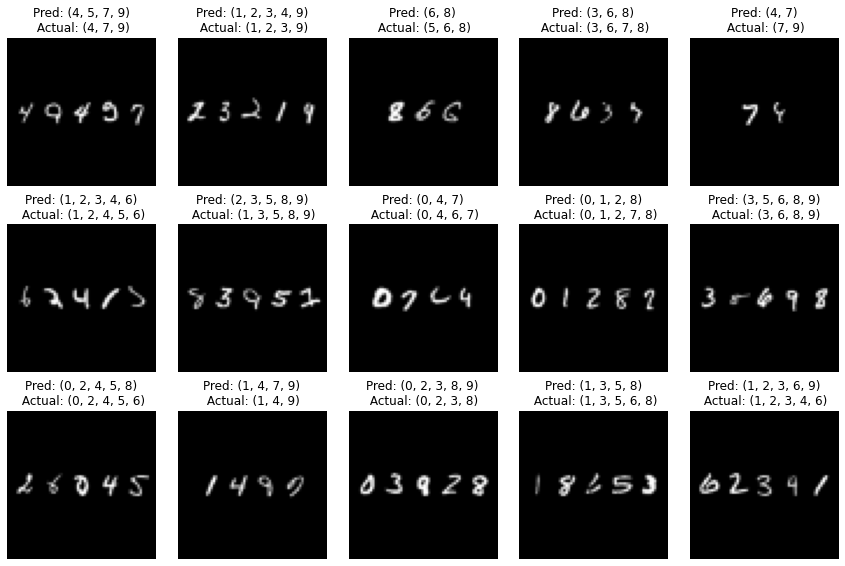

In [0]:
incorrect = np.invert(correct)
images = all_images[incorrect]
labels = ml_binalizer.inverse_transform(y_true[incorrect])
labels_pred = ml_binalizer.inverse_transform(y_pred[incorrect])
plot_images(images, np.array(labels), 3, 5, np.array(labels_pred))

In [0]:
rmtree(MNIST_GENERATED_PATH)

In [0]:
def load_data(path, limit=None):
    data = loadmat(path)
    return data['X'], data['y']

X_train, y_train = load_data(TRAIN_32_x_32_PATH)
X_test, y_test = load_data(TEST_32_x_32_PATH)
X_extra, y_extra = load_data(EXTRA_32_x_32_PATH)

print(f"Training size: X->{X_train.shape}, y->{y_train.shape}")
print(f"Test size: X->{X_test.shape}, y->{y_test.shape}")
print(f"Extra size: X->{X_extra.shape}, y->{y_extra.shape}")

Training size: X->(32, 32, 3, 73257), y->(73257, 1)
Test size: X->(32, 32, 3, 26032), y->(26032, 1)
Extra size: X->(32, 32, 3, 531131), y->(531131, 1)


In [0]:
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]
X_extra, y_extra = X_extra.transpose((3,0,1,2)), y_extra[:,0]
X_extra=X_extra[:100000]
y_extra=y_extra[:100000]
num_images = X_train.shape[0] + X_test.shape[0] + X_extra.shape[0]
print(f"Total Number of Images: {num_images}")
last_idx=0
svhn_single = pd.DataFrame(columns=["image_path", "label", "dataset_type"])
for image, label in zip(X_train, y_train):
    path_to_image=f"{SVHN_SINGLE_PATH}/train/{last_idx}.png"
    imsave(path_to_image, img_as_ubyte(rgb2gray(image)), check_contrast=False)
    svhn_single.loc[last_idx] = [path_to_image, str(label) if label!=10 else '0', "train"]
    last_idx+=1
for image, label in zip(X_extra, y_extra):
    path_to_image=f"{SVHN_SINGLE_PATH}/train/{last_idx}.png"
    imsave(path_to_image, img_as_ubyte(rgb2gray(image)), check_contrast=False)
    svhn_single.loc[last_idx] = [path_to_image, str(label) if label!=10 else '0', "train"]
    last_idx+=1
for image, label in zip(X_test, y_test):
    path_to_image=f"{SVHN_SINGLE_PATH}/test/{last_idx}.png"
    imsave(path_to_image, img_as_ubyte(rgb2gray(image)), check_contrast=False)
    svhn_single.loc[last_idx] = [path_to_image, str(label) if label!=10 else '0', "test"]
    last_idx+=1
del X_train, X_test, X_extra
svhn_single.head()

Total Number of Images: 199289


,image_path,label,dataset_type
0,data/mnist_single/train/0.png,1,train
1,data/mnist_single/train/1.png,9,train
2,data/mnist_single/train/2.png,2,train
3,data/mnist_single/train/3.png,3,train
4,data/mnist_single/train/4.png,2,train


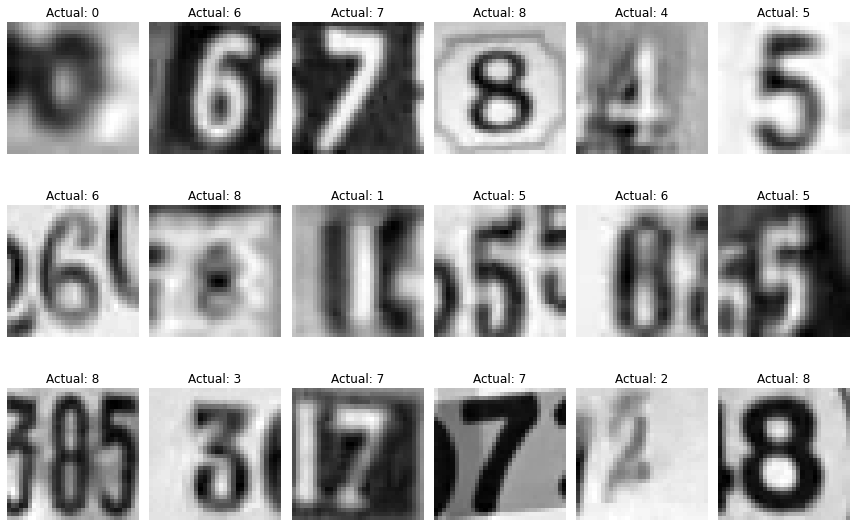

In [0]:
plot_images(*x_y_from_dataframe(svhn_single[svhn_single.dataset_type=="train"].sample(20), (32, 32), "image_path", "label"), 3, 6)

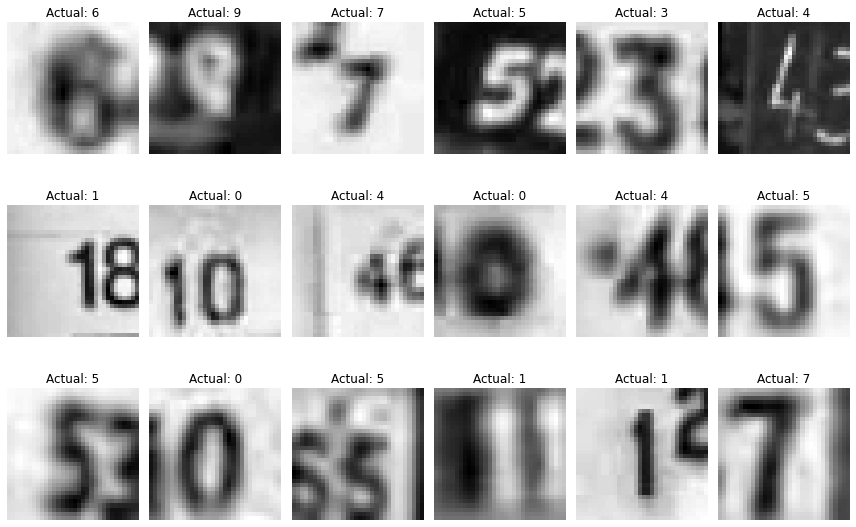

In [0]:
plot_images(*x_y_from_dataframe(svhn_single[svhn_single.dataset_type=="test"].sample(20), (32, 32), "image_path", "label"), 3, 6)

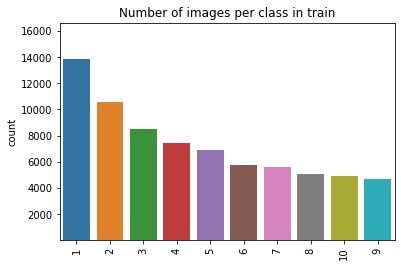

In [0]:
plot_digits_distribution(y_train, "train")

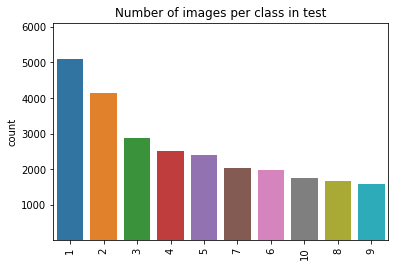

In [0]:
plot_digits_distribution(y_test, "test")

In [0]:
img_size = 32
num_channels = 1
num_classes = 10

In [0]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
train_iterator=train_datagen.flow_from_dataframe(
    svhn_single[svhn_single.dataset_type=="train"],
    x_col="image_path",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    class_mode="categorical",
    classes=list(str(i) for i in range(10)),
    shuffle=True,
    subset='training'
)
valid_iterator=train_datagen.flow_from_dataframe(
    svhn_single[svhn_single.dataset_type=="train"],
    x_col="image_path",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    class_mode="categorical",
    classes=list(str(i) for i in range(10)),
    shuffle=True,
    subset='validation'
)
test_iter=test_datagen.flow_from_dataframe(
    svhn_single[svhn_single.dataset_type=="test"],
    x_col="image_path",
    y_col="label",
    target_size=(img_size, img_size),
    class_mode="categorical",
    classes=list(str(i) for i in range(10)),
    color_mode="grayscale",
    shuffle=False
)

Found 138606 validated image filenames belonging to 10 classes.
Found 34651 validated image filenames belonging to 10 classes.
Found 26032 validated image filenames belonging to 10 classes.


In [0]:
chanDim = -1
model_2 = Sequential()
model_2.add(Conv2D(32, kernel_size=(5,5), activation='relu', padding='same',
                 input_shape=(img_size, img_size, 1)))
model_2.add(BatchNormalization(axis=chanDim))
model_2.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model_2.add(Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'))
model_2.add(BatchNormalization(axis=chanDim))
model_2.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(64, kernel_size=(5,5), activation='relu', padding='same'))
model_2.add(BatchNormalization(axis=chanDim))
model_2.add(MaxPooling2D(pool_size=(2,2), strides=(1,1))) 
model_2.add(Conv2D(64, kernel_size=(5,5), activation='relu', padding='same'))
model_2.add(BatchNormalization(axis=chanDim))
model_2.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2))) 
model_2.add(Dropout(0.25))
model_2.add(Conv2D(128, kernel_size=(5,5), activation='relu', padding='same'))
model_2.add(BatchNormalization(axis=chanDim))
model_2.add(MaxPooling2D(pool_size=(2,2), strides=(1,1))) 
model_2.add(Conv2D(128, kernel_size=(5,5), activation='relu', padding='same'))
model_2.add(BatchNormalization(axis=chanDim))
model_2.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2))) 
model_2.add(Dropout(0.25))
model_2.add(Conv2D(196, kernel_size=(5,5), activation='relu', padding='same'))
model_2.add(BatchNormalization(axis=chanDim))
model_2.add(MaxPooling2D(pool_size=(2,2), strides=(1,1))) 
model_2.add(Conv2D(196, kernel_size=(5,5), activation='relu', padding='same'))
model_2.add(BatchNormalization(axis=chanDim))
model_2.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2))) 
model_2.add(Dropout(0.25))
model_2.add(Flatten())
model_2.add(Dense(512, activation='relu'))
model_2.add(Dense(10, activation='sigmoid'))
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 32)        832       
_________________________________________________________________
batch_normalization_21 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 32)        25632     
_________________________________________________________________
batch_normalization_22 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 8, 8, 32)         

In [0]:
svhn_signle_metrics_valid = Metrics(valid_iterator)
svhn_signle_metrics_train = Metrics(train_iterator)

In [0]:
filepath="data/model_weights/weights-svhn-single-number.hdf5"
callbacks=[
    EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
    svhn_signle_metrics_train,
    svhn_signle_metrics_valid
]
history= model_2.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=30, verbose=1, validation_data=valid_iterator, validation_steps=len(valid_iterator), callbacks=callbacks)
loss, accuracy = model_2.evaluate(test_iter, steps=len(test_iter), verbose=1)

Epoch 1/50
4332/4332 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 0.8715
Epoch 00001: val_loss improved from inf to 0.05979, saving model to data/model_weights/weights-svhn-single-number.hdf5
validation scores: F1-0.943 - Precision: 0.958 - Recall: 0.929
Accuracy: 0.924 - Hamming loss 0.011
validation scores: F1-0.894 - Precision: 0.926 - Recall: 0.868
Accuracy: 0.862 - Hamming loss 0.020
4332/4332 [==============================] - 129s 30ms/step - loss: 0.0685 - accuracy: 0.8715 - val_loss: 0.0598 - val_accuracy: 0.8911
Epoch 2/50
4329/4332 [============================>.] - ETA: 0s - loss: 0.0372 - accuracy: 0.9353
Epoch 00002: val_loss improved from 0.05979 to 0.05280, saving model to data/model_weights/weights-svhn-single-number.hdf5
validation scores: F1-0.957 - Precision: 0.970 - Recall: 0.945
Accuracy: 0.942 - Hamming loss 0.008
validation scores: F1-0.908 - Precision: 0.938 - Recall: 0.882
Accuracy: 0.878 - Hamming loss 0.018
4332/4332 [===============

Model loss=0.03686312958598137, accuracy=0.9400737285614014


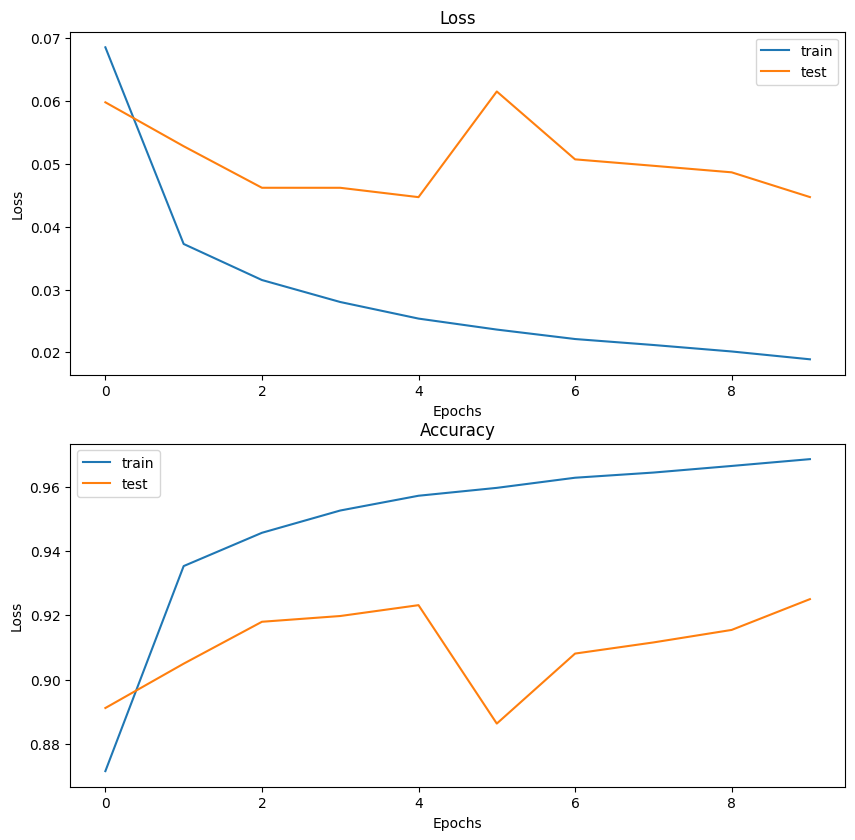

In [0]:
print(f"Model loss={loss}, accuracy={accuracy}")
plot_history(history)

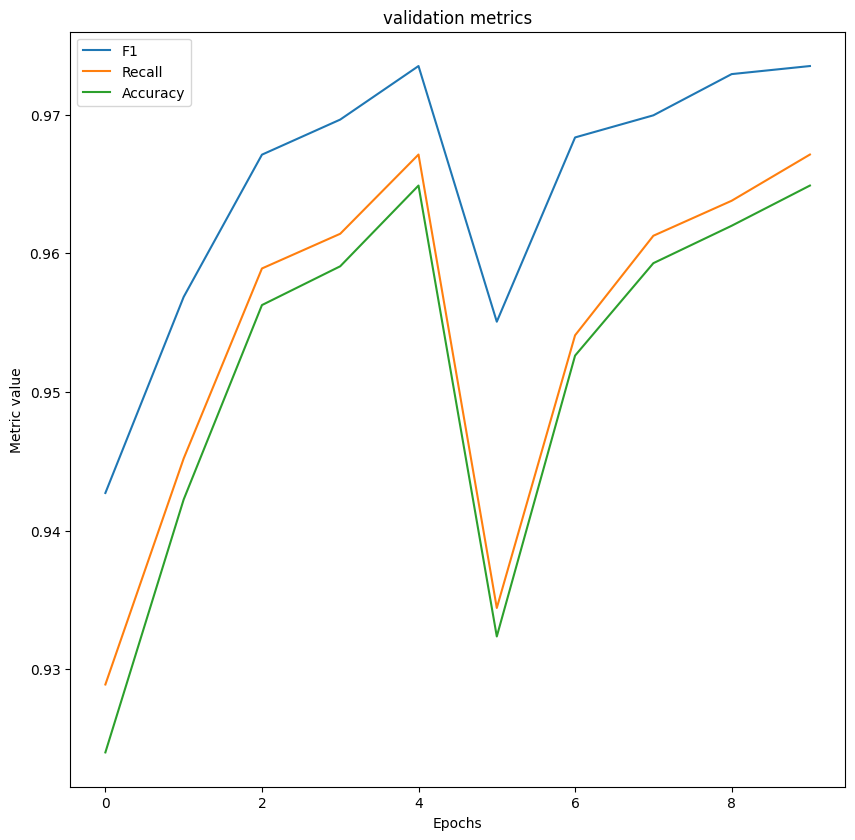

In [0]:
plot_metrics(svhn_signle_metrics_train)

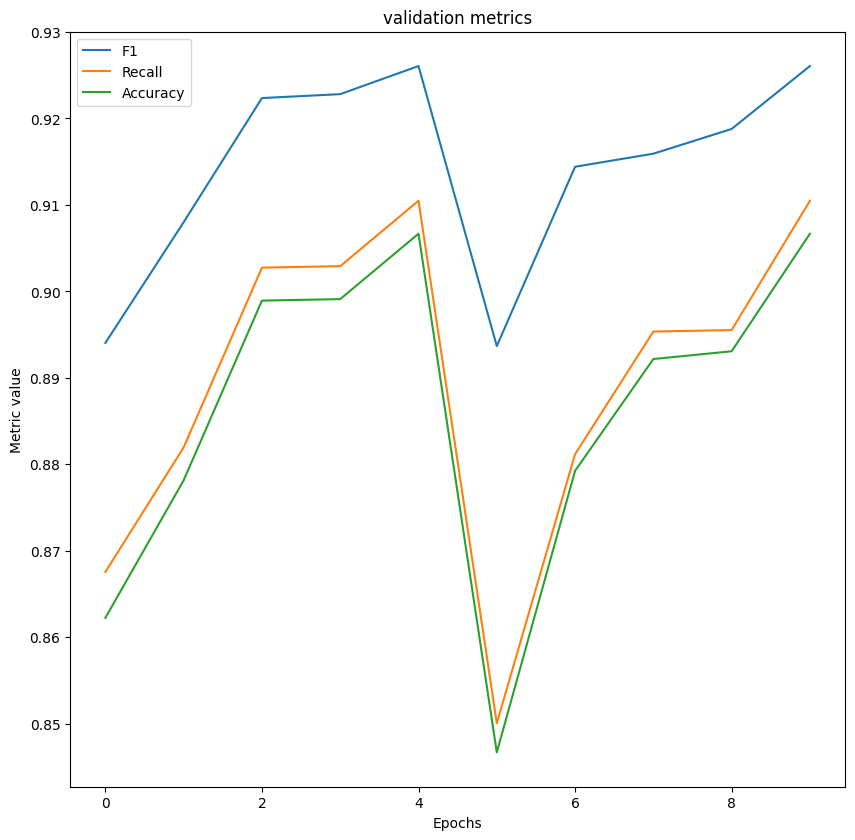

In [0]:
plot_metrics(svhn_signle_metrics_valid)

In [0]:
test_iter.reset()
gen_1, gen_2 = tee(test_iter)
y_true = np.vstack(tuple(next(gen_1)[1] for _ in range(len(test_iter))))
y_pred = model_2.predict(gen_2, steps=len(test_iter))

In [0]:
pred=np.zeros(y_pred.shape)
pred[np.arange(y_pred.shape[0]), np.argmax(y_pred, axis=1)]=1
precision = sk_metrics.precision_score(y_true, pred, average='weighted')
recall = sk_metrics.recall_score(y_true, pred, average='weighted')
f1 = sk_metrics.f1_score(y_true, pred, average='weighted')
accuracy = sk_metrics.accuracy_score(y_true, pred)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-measure: {f1:.4f}, Accuracy: {accuracy:.4f}")

Precision: 0.9404, Recall: 0.9401, F1-measure: 0.9401, Accuracy: 0.9401


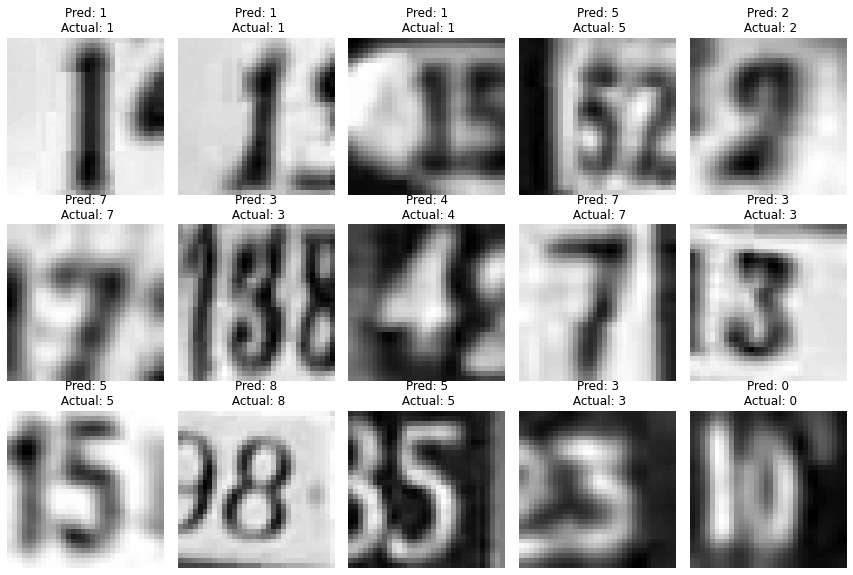

In [0]:
test_iter.reset()
ml_binalizer=LabelBinarizer()
ml_binalizer.fit(svhn_single['label'].tolist())
y_pred_converted=np.zeros(y_pred.shape)
y_pred_converted[np.arange(y_pred.shape[0]), np.argmax(y_pred, axis=1)]=1
y_pred=y_pred_converted
correct = (y_pred==y_true).all(axis=1)
all_images=np.vstack(tuple(next(test_iter)[0] for _ in range(len(test_iter))))
images = all_images[correct]
labels = ml_binalizer.inverse_transform(y_true[correct])
labels_pred = ml_binalizer.inverse_transform(y_pred[correct])
plot_images(images, np.array(labels), 3, 5, np.array(labels_pred))

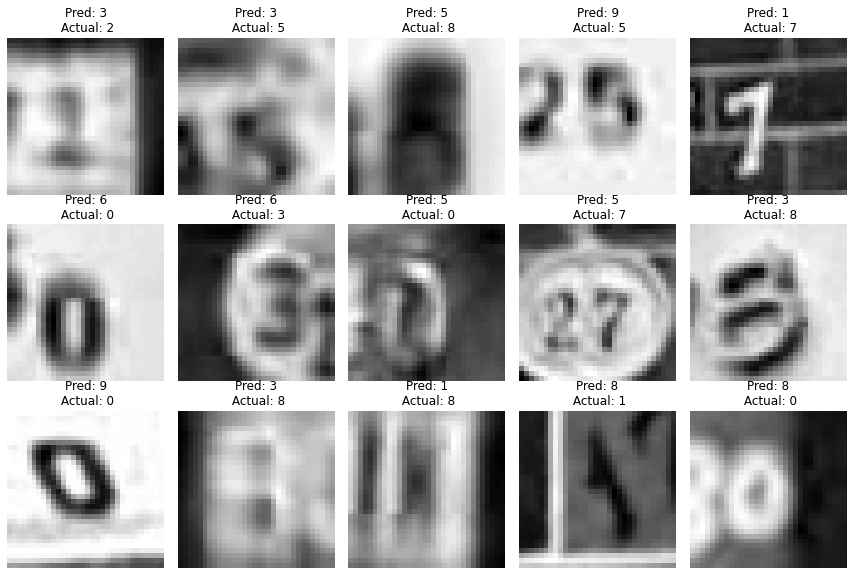

In [0]:
incorrect = np.invert(correct)
images = all_images[incorrect]
labels = ml_binalizer.inverse_transform(y_true[incorrect])
labels_pred = ml_binalizer.inverse_transform(y_pred[incorrect])
plot_images(images, np.array(labels), 3, 5, np.array(labels_pred))

In [0]:
rmtree(SVHN_SINGLE_PATH)

In [0]:
def get_bounding_boxes(start_path = '.'):
    return DigitStructWrapper(start_path).unpack_all()

train_bbox = get_bounding_boxes(f'{SVHN_IMAGES_PATH}/train/digitStruct.mat')
test_bbox = get_bounding_boxes(f'{SVHN_IMAGES_PATH}/test/digitStruct.mat')
extra_bbox = get_bounding_boxes(f'{SVHN_IMAGES_PATH}/extra/digitStruct.mat')

print(json.dumps(train_bbox[0]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


{"filename": "1.png", "boxes": [{"height": 219.0, "label": 1.0, "left": 246.0, "top": 77.0, "width": 81.0}, {"height": 219.0, "label": 9.0, "left": 323.0, "top": 81.0, "width": 96.0}]}


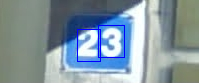

In [0]:
def display_bounding_boxes(img, bounding_boxes):
    image = Image.open(img)
    draw = ImageDraw.Draw(image)
    for b in bounding_boxes:
        rectangle = [b['left'], b['top'], b['left'] + b['width'], b['top'] + b['height']]
        draw.rectangle(rectangle, outline="blue")
    return image

image = f'{SVHN_IMAGES_PATH}/train/2.png'
image_bounding_boxes = train_bbox[1]['boxes']
display_bounding_boxes(image, image_bounding_boxes)

In [14]:
def dict_to_dataframe(image_bounding_boxes, path):
    boxes = []
    for image in image_bounding_boxes:
        for bbox in image['boxes']:
            boxes.append({
                    'filename': path + image['filename'],
                    'label': int(bbox['label']),
                    'width': bbox['width'],
                    'height': bbox['height'],
                    'top': bbox['top'],
                    'left': bbox['left']})
    return pd.DataFrame(boxes)
bbox_file = f'drive/My Drive/colabFiles/bounding_boxes.csv'
if not os.path.exists(bbox_file):
    train_df = dict_to_dataframe(train_bbox, f'{SVHN_IMAGES_PATH}/train/')
    test_df = dict_to_dataframe(test_bbox, f'{SVHN_IMAGES_PATH}/test/')
    extra_df = dict_to_dataframe(extra_bbox, f'{SVHN_IMAGES_PATH}/extra/')
    print("Training", train_df.shape)
    print("Test", test_df.shape)
    print("Extra", extra_df.shape)
    svhn_multi_df = pd.concat([train_df, test_df, extra_df])
    print("Combined", svhn_multi_df.shape)
    svhn_multi_df.to_csv(bbox_file, index=False)
    del train_df, test_df, extra_df, train_bbox, test_bbox, extra_bbox
else:
    svhn_multi_df = pd.read_csv(bbox_file, error_bad_lines=False)
svhn_multi_df.head()

,filename,label,width,height,top,left
0,data/svhn/train/1.png,1,81.0,219.0,77.0,246.0
1,data/svhn/train/1.png,9,96.0,219.0,81.0,323.0
2,data/svhn/train/2.png,2,23.0,32.0,29.0,77.0
3,data/svhn/train/2.png,3,26.0,32.0,25.0,98.0
4,data/svhn/train/3.png,2,8.0,15.0,5.0,17.0


In [15]:
svhn_multi_df.rename(columns={'left': 'x0', 'top': 'y0'}, inplace=True)
svhn_multi_df['x1'] = svhn_multi_df['x0'] + svhn_multi_df['width']
svhn_multi_df['y1'] = svhn_multi_df['y0'] + svhn_multi_df['height']
svhn_multi_df = svhn_multi_df.groupby('filename').agg(
    x0=('x0', 'min'),
    y0=('y0', 'max'),
    x1=('x1', 'max'),
    y1=('y1', 'max'),
    labels=('label', lambda x: [i if i!= 10 else 0 for i in x]),
    num_digits=('label', 'count')
).reset_index()
svhn_multi_df.head()

,filename,x0,y0,x1,y1,labels,num_digits
0,data/svhn/extra/1.png,24.0,70.0,126.0,126.0,"[4, 7, 8]",3
1,data/svhn/extra/10.png,5.0,7.0,52.0,32.0,"[4, 4, 4]",3
2,data/svhn/extra/100.png,3.0,1.0,46.0,30.0,"[5, 3, 5]",3
3,data/svhn/extra/1000.png,9.0,8.0,36.0,40.0,"[2, 6]",2
4,data/svhn/extra/10000.png,8.0,14.0,41.0,35.0,"[2, 0, 0]",3


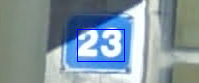

In [16]:
def display_bbox(image_path, bbox):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    draw.rectangle([bbox['x0'], bbox['y0'], bbox['x1'], bbox['y1']], outline="blue")
    return image
image = f'{SVHN_IMAGES_PATH}/train/2.png'
bbox = svhn_multi_df[svhn_multi_df.filename == image]
display_bbox(image, bbox)

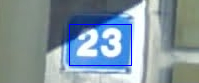

In [17]:
def display_bbox_ext(image_path, bbox):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    draw.rectangle([bbox['x0_ext'], bbox['y0_ext'], bbox['x1_ext'], bbox['y1_ext']], outline="blue")
    return image
svhn_multi_df['x_increase'] = ((svhn_multi_df['x1'] - svhn_multi_df['x0']) * 0.3) / 2.
svhn_multi_df['y_increase'] = ((svhn_multi_df['y1'] - svhn_multi_df['y0']) * 0.3) / 2.
svhn_multi_df['x0_ext'] = (svhn_multi_df['x0'] - svhn_multi_df['x_increase']).astype('int')
svhn_multi_df['y0_ext'] = (svhn_multi_df['y0'] - svhn_multi_df['y_increase']).astype('int')
svhn_multi_df['x1_ext'] = (svhn_multi_df['x1'] + svhn_multi_df['x_increase']).astype('int')
svhn_multi_df['y1_ext'] = (svhn_multi_df['y1'] + svhn_multi_df['y_increase']).astype('int')
image = f'{SVHN_IMAGES_PATH}/train/2.png'
bbox = svhn_multi_df[svhn_multi_df.filename == image]
display_bbox_ext(image, bbox)

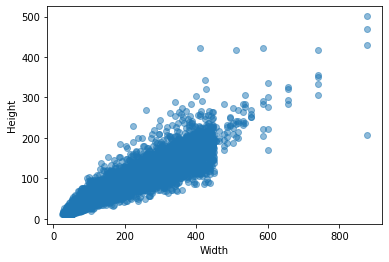

In [18]:
def get_image_size(filepath):
    image = Image.open(filepath)
    return image.size 

def get_image_sizes(folder):
    image_sizes = []
    images = [img for img in os.listdir(folder) if img.endswith('.png')]
    for image in images:
        w, h = get_image_size(folder + image)
        image_size = {'filename': folder + image, 'image_width': w, 'image_height': h}
        image_sizes.append(image_size)
    return pd.DataFrame(image_sizes)

train_sizes = get_image_sizes(f'{SVHN_IMAGES_PATH}/train/')
test_sizes = get_image_sizes(f'{SVHN_IMAGES_PATH}/test/')
extra_sizes = get_image_sizes(f'{SVHN_IMAGES_PATH}/extra/')
image_sizes = pd.concat([train_sizes, test_sizes, extra_sizes])
plt.scatter(train_sizes["image_width"].tolist(), train_sizes["image_height"].tolist(), alpha=0.5)
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()
del train_sizes, test_sizes, extra_sizes

In [19]:
print(f"Bounding boxes {svhn_multi_df.shape}")
print(f"Image sizes {image_sizes.shape}")
svhn_multi_df = pd.merge(svhn_multi_df, image_sizes, on='filename', how='inner')
print(f"Merged {svhn_multi_df.shape}")
del image_sizes
svhn_multi_df.to_csv(f'{SVHN_IMAGES_PATH}/image_data.csv', index=False)
svhn_multi_df.head()

Bounding boxes (248823, 13)
Image sizes (248823, 3)
Merged (248823, 15)


,filename,x0,y0,x1,y1,labels,num_digits,x_increase,y_increase,x0_ext,y0_ext,x1_ext,y1_ext,image_width,image_height
0,data/svhn/extra/1.png,24.0,70.0,126.0,126.0,"[4, 7, 8]",3,15.30,8.40,8,61,141,134,166,141
1,data/svhn/extra/10.png,5.0,7.0,52.0,32.0,"[4, 4, 4]",3,7.05,3.75,-2,3,59,35,52,41
2,data/svhn/extra/100.png,3.0,1.0,46.0,30.0,"[5, 3, 5]",3,6.45,4.35,-3,-3,52,34,51,32
3,data/svhn/extra/1000.png,9.0,8.0,36.0,40.0,"[2, 6]",2,4.05,4.80,4,3,40,44,51,49
4,data/svhn/extra/10000.png,8.0,14.0,41.0,35.0,"[2, 0, 0]",3,4.95,3.15,3,10,45,38,55,44


In [20]:
svhn_multi_df.loc[svhn_multi_df['x0_ext'] < 0, 'x0_ext'] = 0
svhn_multi_df.loc[svhn_multi_df['y0_ext'] < 0, 'y0_ext'] = 0
svhn_multi_df.loc[svhn_multi_df['x1_ext'] > svhn_multi_df['image_width'], 'x1_ext'] = svhn_multi_df['image_width']
svhn_multi_df.loc[svhn_multi_df['y1_ext'] > svhn_multi_df['image_height'], 'y1_ext'] = svhn_multi_df['image_width']
svhn_multi_df.head()

,filename,x0,y0,x1,y1,labels,num_digits,x_increase,y_increase,x0_ext,y0_ext,x1_ext,y1_ext,image_width,image_height
0,data/svhn/extra/1.png,24.0,70.0,126.0,126.0,"[4, 7, 8]",3,15.30,8.40,8,61,141,134,166,141
1,data/svhn/extra/10.png,5.0,7.0,52.0,32.0,"[4, 4, 4]",3,7.05,3.75,0,3,52,35,52,41
2,data/svhn/extra/100.png,3.0,1.0,46.0,30.0,"[5, 3, 5]",3,6.45,4.35,0,0,51,51,51,32
3,data/svhn/extra/1000.png,9.0,8.0,36.0,40.0,"[2, 6]",2,4.05,4.80,4,3,40,44,51,49
4,data/svhn/extra/10000.png,8.0,14.0,41.0,35.0,"[2, 0, 0]",3,4.95,3.15,3,10,45,38,55,44


In [21]:
svhn_multi_df.num_digits.value_counts(sort=False)

1     17005
2     98212
3    117561
4     15918
5       126
6         1
Name: num_digits, dtype: int64

In [0]:
svhn_multi_df = svhn_multi_df[svhn_multi_df.num_digits < 6]

In [23]:
svhn_multi_df[['image_width', 'image_height']].describe().round(decimals=2)

,image_width,image_height
count,248822.00,248822.00
mean,107.93,60.88
std,63.22,32.39
min,22.00,12.00
25%,69.00,40.00
50%,92.00,53.00
75%,127.00,74.00
max,1083.00,516.00


In [0]:
svhn_multi_df = svhn_multi_df[svhn_multi_df.image_height>=40]

In [0]:
def crop_and_resize(img_info, img_size):
    image_data = imread(img_info['filename'])
    crop = image_data[int(img_info['y0_ext']):int(img_info['y1_ext']), int(img_info['x0_ext']):int(img_info['x1_ext']), :]
    return resize(crop, img_size).astype(np.float32)

In [0]:
def to_gray(image):
    return rgb2gray(image).astype(np.float32)
image_size = (70, 70)
PREPROCESSED_PATH=f'data/svhn/preprocessed'
if os.path.exists(PREPROCESSED_PATH):
    for index, img_info in list(svhn_multi_df.iterrows()):
        img_type=img_info['filename'].split("/")[-2]
        img_filename=img_info['filename'].split("/")[-1]
        image_prprocessed_path=f"{PREPROCESSED_PATH}/{img_type}/{img_filename}"
        svhn_multi_df.at[index,'preproccessed_filename']=image_prprocessed_path
else:
    makedirs(f'{PREPROCESSED_PATH}', exist_ok=True)
    makedirs(f'{PREPROCESSED_PATH}/train', exist_ok=True)
    makedirs(f'{PREPROCESSED_PATH}/test', exist_ok=True)
    makedirs(f'{PREPROCESSED_PATH}/extra', exist_ok=True)
    index_to_drop=[]
    for index, img_info in list(svhn_multi_df.iterrows()):
        cropped_image=to_gray(crop_and_resize(img_info, image_size))
        if not is_low_contrast(cropped_image):
            img_type=img_info['filename'].split("/")[-2]
            img_filename=img_info['filename'].split("/")[-1]
            image_prprocessed_path=f"{PREPROCESSED_PATH}/{img_type}/{img_filename}"
            imsave(image_prprocessed_path, img_as_ubyte(cropped_image))
            svhn_multi_df.at[index,'preproccessed_filename']=image_prprocessed_path
        else:
            index_to_drop.append(index)
    svhn_multi_df=svhn_multi_df.drop(index_to_drop)


In [0]:
svhn_multi_df.loc[svhn_multi_df.filename.str.contains('test'), 'dataset_type'] = 'test'
svhn_multi_df.loc[~svhn_multi_df.filename.str.contains('test'), 'dataset_type'] = 'train'
df_valid=svhn_multi_df[svhn_multi_df.dataset_type=='train'].sample(20000)
df_valid.dataset_type='validation'
svhn_multi_df.update(df_valid)

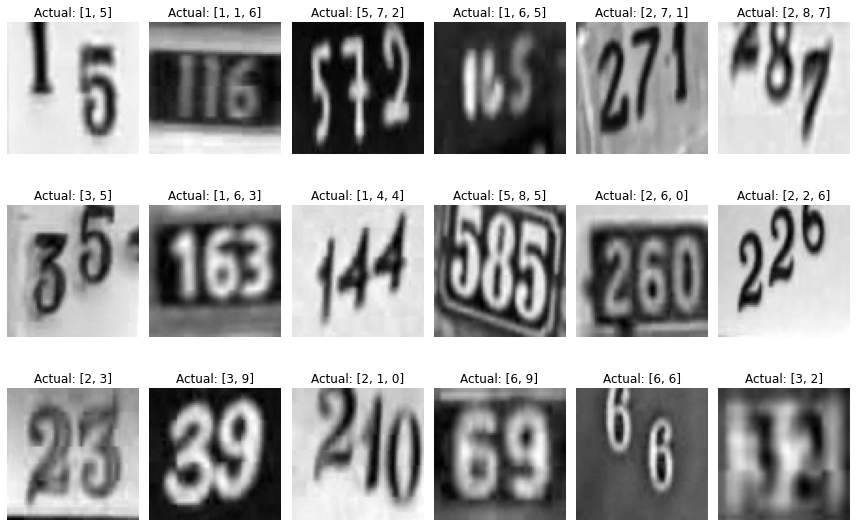

In [28]:
plot_images(*x_y_from_dataframe(svhn_multi_df[svhn_multi_df.dataset_type=="train"].sample(20), (70, 70), "preproccessed_filename", "labels"), 3, 6)

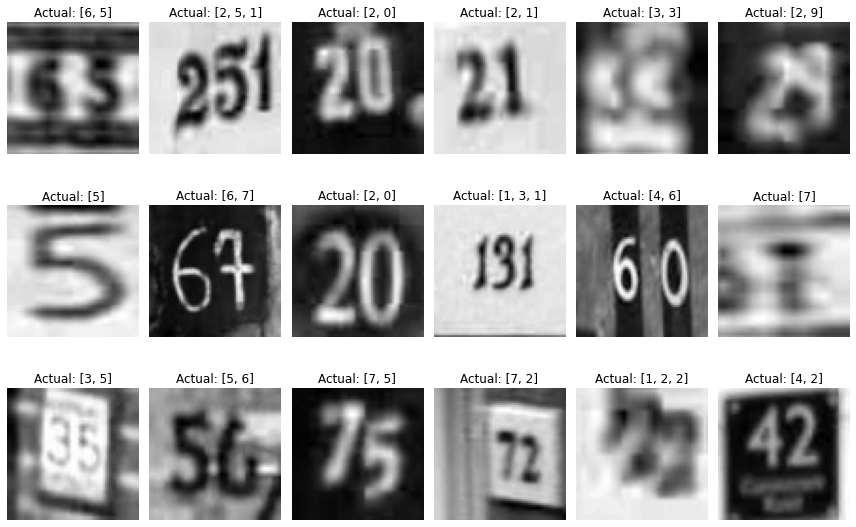

In [29]:
plot_images(*x_y_from_dataframe(svhn_multi_df[svhn_multi_df.dataset_type=="test"].sample(20), (70, 70), "preproccessed_filename", "labels"), 3, 6)

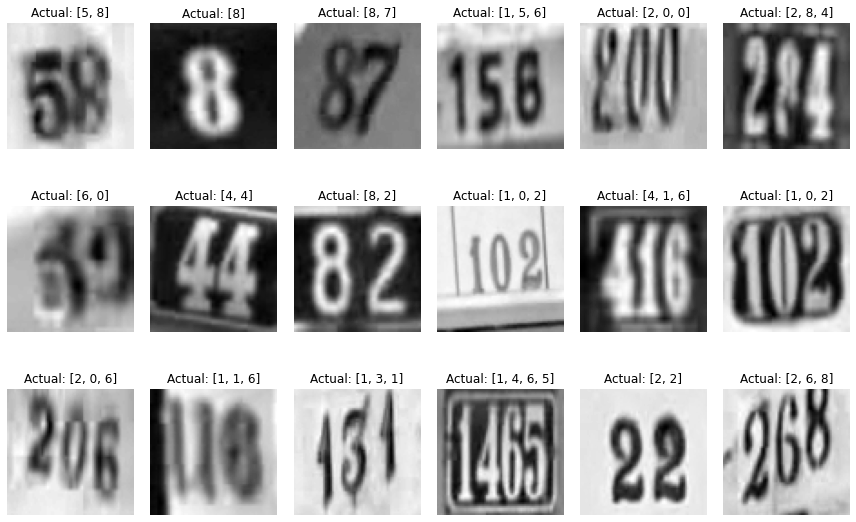

In [30]:
plot_images(*x_y_from_dataframe(svhn_multi_df[svhn_multi_df.dataset_type=="validation"].sample(20), (70, 70), "preproccessed_filename", "labels"), 3, 6)

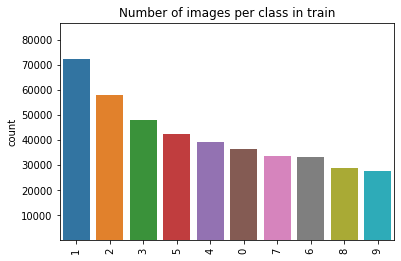

In [31]:
plot_digits_distribution(svhn_multi_df[svhn_multi_df.dataset_type=="train"]["labels"].to_list(), "train")

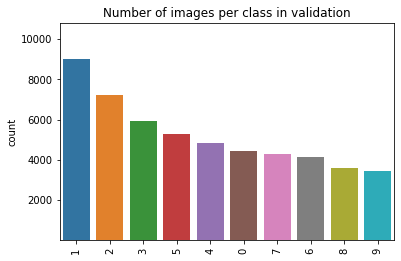

In [32]:
plot_digits_distribution(svhn_multi_df[svhn_multi_df.dataset_type=="validation"]["labels"].tolist(), "validation")

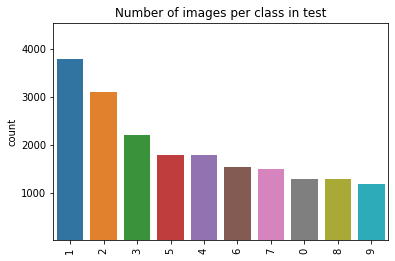

In [33]:
plot_digits_distribution(svhn_multi_df[svhn_multi_df.dataset_type=="test"]["labels"].tolist(), "test")

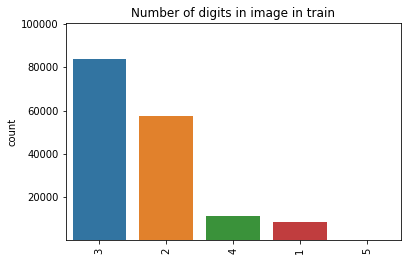

In [34]:
plot_number_length_distribution(svhn_multi_df[svhn_multi_df.dataset_type=="train"]["labels"].tolist(), "train")

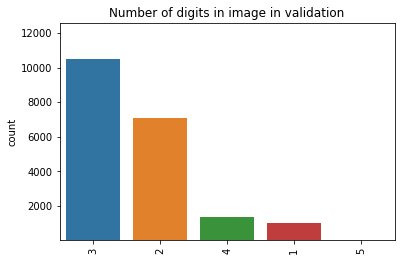

In [35]:
plot_number_length_distribution(svhn_multi_df[svhn_multi_df.dataset_type=="validation"]["labels"].tolist(), "validation")

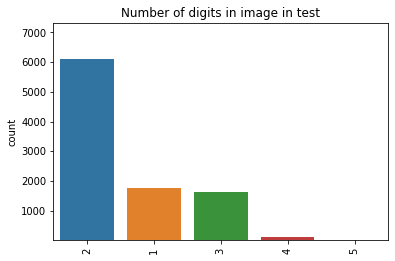

In [36]:
plot_number_length_distribution(svhn_multi_df[svhn_multi_df.dataset_type=="test"]["labels"].tolist(), "test")

In [0]:
def random_crop(image, crop_margin=18):
    image=resize(image, (image.shape[0]+crop_margin, image.shape[1]+crop_margin), preserve_range=True)
    margin_x = int(random.uniform(0, crop_margin))
    margin_y = int(random.uniform(0, crop_margin))
    return image[margin_x:-(crop_margin-margin_x), margin_y:-(crop_margin-margin_y)]

In [0]:
def random_perspective(image):
    region = 1/4
    A = np.array([[0, 0], [0, image.shape[0]], [image.shape[1], image.shape[0]], [image.shape[1], 0]])
    B = np.array([[int(random.uniform(0, image.shape[1] * region)), int(random.uniform(0, image.shape[0] * region))], 
                  [int(random.uniform(0, image.shape[1] * region)), int(random.uniform(image.shape[0] * (1-region), image.shape[0]))], 
                  [int(random.uniform(image.shape[1] * (1-region), image.shape[1])), int(random.uniform(image.shape[0] * (1-region), image.shape[0]))], 
                  [int(random.uniform(image.shape[1] * (1-region), image.shape[1])), int(random.uniform(0, image.shape[0] * region))], 
                 ])
    pt = ProjectiveTransform()
    pt.estimate(A, B)
    return warp(image, pt, output_shape=image.shape[:2])

In [0]:
class SequenceWrapper(Sequence):
    def __init__(self, wrapping_sequence):
        self.wrapping_sequence=wrapping_sequence

    def __len__(self):
        return self.wrapping_sequence.__len__() 

    def __getitem__(self, idx):
        X_batch, y_batch=self.wrapping_sequence[idx]
        batch_size=y_batch.shape[0]
        num_of_classes=y_batch[0].shape[0]
        y_batch=np.concatenate(y_batch, axis=0).reshape(batch_size, num_of_classes)
        return X_batch, y_batch
    
    def __iter__(self):
        return self
    
    def __next__(self):
        X_batch, y_batch=next(self.wrapping_sequence)
        batch_size=y_batch.shape[0]
        num_of_classes=y_batch[0].shape[0]
        y_batch=np.concatenate(y_batch, axis=0).reshape(batch_size, num_of_classes)
        return X_batch, y_batch

In [40]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,
    preprocessing_function=lambda image: random.choice([
        lambda img: random_crop(img),
        lambda img: img
    ])(image)
)
train_iterator=train_datagen.flow_from_dataframe(
    svhn_multi_df[svhn_multi_df.dataset_type=='train'],
    x_col="preproccessed_filename",
    y_col="labels",
    target_size=(54, 54),
    color_mode="grayscale",
    class_mode="categorical",
    classes=list(range(10)),
    shuffle=True,
    batch_size=128
)
validation_datagen= ImageDataGenerator(rescale=1/255)
validation_iter=validation_datagen.flow_from_dataframe(
    svhn_multi_df[svhn_multi_df.dataset_type=='validation'],
    x_col="preproccessed_filename",
    y_col="labels",
    target_size=(54, 54),
    class_mode="categorical",
    classes=list(range(10)),
    color_mode="grayscale",
    shuffle=True,
    batch_size=128
)
test_datagen = ImageDataGenerator(rescale=1/255)
test_iter=test_datagen.flow_from_dataframe(
    svhn_multi_df[svhn_multi_df.dataset_type=='test'],
    x_col="preproccessed_filename",
    y_col="labels",
    target_size=(54, 54),
    class_mode="categorical",
    classes=list(range(10)),
    color_mode="grayscale",
    batch_size=128,
    shuffle=False
)

Found 161010 validated image filenames belonging to 10 classes.
Found 20000 validated image filenames belonging to 10 classes.
Found 9629 validated image filenames belonging to 10 classes.


In [0]:
svhn_multi_valid = Metrics(validation_iter, dataset_type="Validation")
svhn_multi_train = Metrics(train_iterator, dataset_type="Train", steps=200)

In [42]:
num_classes=10
num_channels=1
img_size=54
chanDim = -1
model_3 = Sequential()
model_3.add(Conv2D(32, kernel_size=(5,5), activation='relu', padding='same',
                 input_shape=(img_size, img_size, num_channels)))
model_3.add(BatchNormalization(axis=chanDim))
model_3.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model_3.add(Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'))
model_3.add(BatchNormalization(axis=chanDim))
model_3.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model_3.add(Dropout(0.25))
model_3.add(Conv2D(64, kernel_size=(5,5), activation='relu', padding='same'))
model_3.add(BatchNormalization(axis=chanDim))
model_3.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model_3.add(Conv2D(64, kernel_size=(5,5), activation='relu', padding='same'))
model_3.add(BatchNormalization(axis=chanDim))
model_3.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model_3.add(Dropout(0.25))
model_3.add(Conv2D(128, kernel_size=(5,5), activation='relu', padding='same'))
model_3.add(BatchNormalization(axis=chanDim))
model_3.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model_3.add(Conv2D(128, kernel_size=(5,5), activation='relu', padding='same'))
model_3.add(BatchNormalization(axis=chanDim))
model_3.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model_3.add(Dropout(0.25))
model_3.add(Conv2D(196, kernel_size=(5,5), activation='relu', padding='same'))
model_3.add(BatchNormalization(axis=chanDim))
model_3.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model_3.add(Conv2D(196, kernel_size=(5,5), activation='relu', padding='same'))
model_3.add(BatchNormalization(axis=chanDim))
model_3.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model_3.add(Dropout(0.25))
model_3.add(Flatten())
model_3.add(Dense(512, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))
model_3.add(Dense(512, activation='relu'))
model_3.add(Dense(num_classes, activation='sigmoid'))
model_3.compile(optimizer=RMSprop(lr=0.0001, decay=1e-6), loss='binary_crossentropy')
model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 54, 54, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 53, 53, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 52, 52, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 52, 52, 32)        0

In [43]:
filepath="drive/My Drive/colabFiles/weights-svhn-multiple-numbers.hdf5"
callbacks=[
    EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
    svhn_multi_train,
    svhn_multi_valid
]
history= model_3.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=30, verbose=1, validation_data=validation_iter, validation_steps=len(validation_iter), callbacks=callbacks)
results = model_3.evaluate(test_iter, steps=len(test_iter), verbose=1)

Epoch 1/30
1258/1258 [==============================] - ETA: 0s - loss: 0.4045
Epoch 00001: val_loss improved from inf to 0.16556, saving model to drive/My Drive/colabFiles/weights-svhn-multiple-numbers.hdf5
Train scores: F1-0.806 - Precision: 0.844 - Recall: 0.788
Accuracy: 0.454 - Hamming loss 0.090
Validation scores: F1-0.868 - Precision: 0.886 - Recall: 0.863
Accuracy: 0.599 - Hamming loss 0.062
1258/1258 [==============================] - 370s 295ms/step - loss: 0.4045 - val_loss: 0.1656
Epoch 2/30
1258/1258 [==============================] - ETA: 0s - loss: 0.1630
Epoch 00002: val_loss improved from 0.16556 to 0.06460, saving model to drive/My Drive/colabFiles/weights-svhn-multiple-numbers.hdf5
Train scores: F1-0.917 - Precision: 0.936 - Recall: 0.900
Accuracy: 0.722 - Hamming loss 0.039
Validation scores: F1-0.954 - Precision: 0.961 - Recall: 0.949
Accuracy: 0.841 - Hamming loss 0.022
1258/1258 [==============================] - 377s 300ms/step - loss: 0.1630 - val_loss: 0.0646


In [44]:
print(f"Model loss={results}")

Model loss=0.04677972197532654


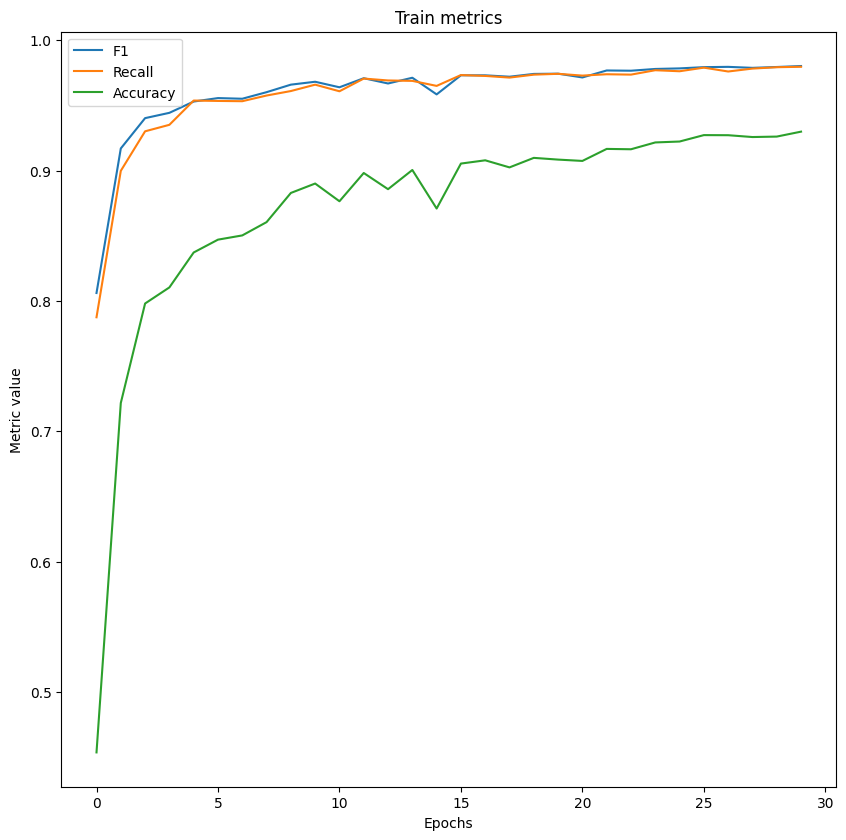

In [45]:
plot_metrics(svhn_multi_train)

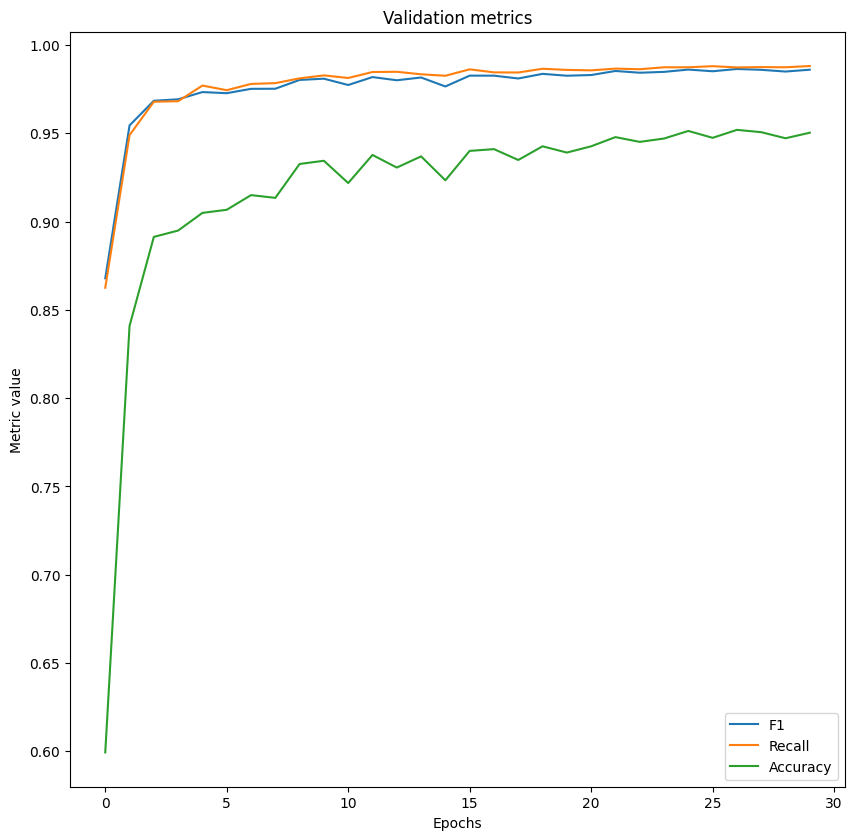

In [46]:
plot_metrics(svhn_multi_valid)

In [0]:
test_iter.reset()
gen_1, gen_2 = tee(test_iter)
y_true = np.vstack(tuple(next(gen_1)[1] for _ in range(len(test_iter))))
y_pred = model_3.predict(gen_2, steps=len(test_iter))

In [48]:
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=y_pred.copy()
    pred[pred>=val]=1
    pred[pred<val]=0
    precision = sk_metrics.precision_score(y_true, pred, average='weighted')
    recall = sk_metrics.recall_score(y_true, pred, average='weighted')
    f1 = sk_metrics.f1_score(y_true, pred, average='weighted')
    print(f"Threshold: {val}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-measure: {f1:.4f}")

Threshold: 0.1, Precision: 0.8814, Recall: 0.9846, F1-measure: 0.9299
Threshold: 0.2, Precision: 0.9190, Recall: 0.9794, F1-measure: 0.9481
Threshold: 0.3, Precision: 0.9387, Recall: 0.9754, F1-measure: 0.9565
Threshold: 0.4, Precision: 0.9501, Recall: 0.9712, F1-measure: 0.9604
Threshold: 0.5, Precision: 0.9588, Recall: 0.9654, F1-measure: 0.9620
Threshold: 0.6, Precision: 0.9669, Recall: 0.9605, F1-measure: 0.9636
Threshold: 0.7, Precision: 0.9726, Recall: 0.9539, F1-measure: 0.9631
Threshold: 0.8, Precision: 0.9796, Recall: 0.9455, F1-measure: 0.9622
Threshold: 0.9, Precision: 0.9858, Recall: 0.9315, F1-measure: 0.9578


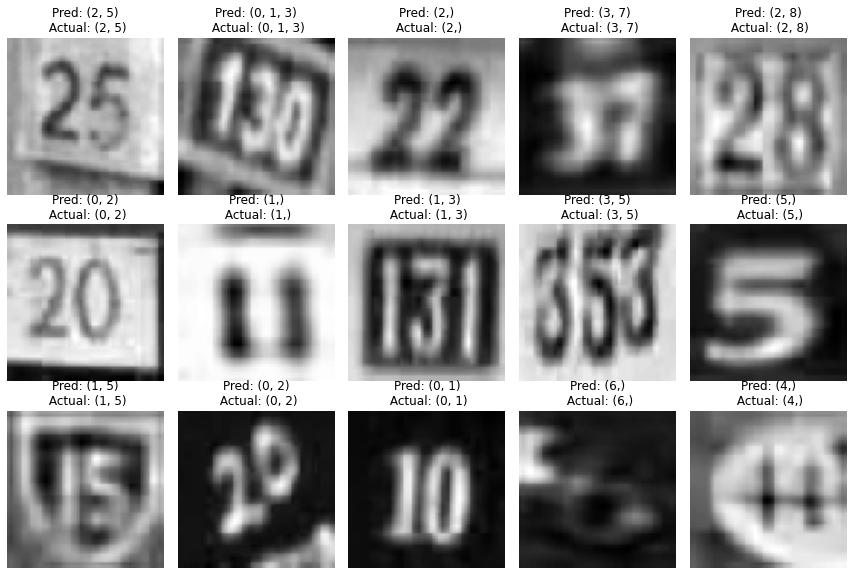

In [49]:
test_iter.reset()
ml_binalizer=MultiLabelBinarizer()
ml_binalizer.fit(svhn_multi_df['labels'].tolist())
y_pred = (y_pred>=0.5).astype('int')
correct = (y_pred==y_true).all(axis=1)
all_images=np.vstack(tuple(next(test_iter)[0] for _ in range(len(test_iter))))
images = all_images[correct]
labels = ml_binalizer.inverse_transform(y_true[correct])
labels_pred = ml_binalizer.inverse_transform(y_pred[correct])
plot_images(images, np.array(labels), 3, 5, np.array(labels_pred))

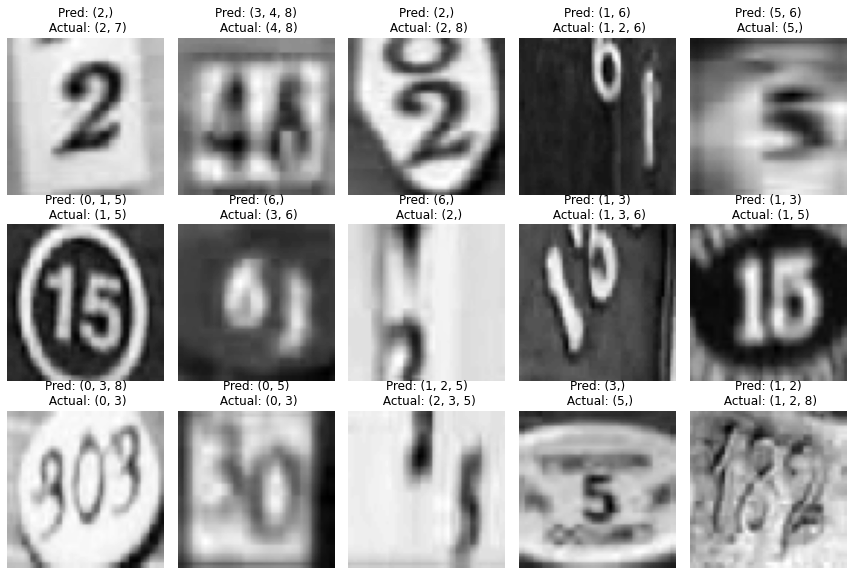

In [50]:
incorrect = np.invert(correct)
images = all_images[incorrect]
labels = ml_binalizer.inverse_transform(y_true[incorrect])
labels_pred = ml_binalizer.inverse_transform(y_pred[incorrect])
plot_images(images, np.array(labels), 3, 5, np.array(labels_pred))

In [51]:
def calculate_accuracy(y_true, y_pred):
    return  sk_metrics.precision_score(y_true, y_pred, average='weighted')
    

for num_digits in range(1, 6):
    images = y_true.sum(1) == num_digits
    acc = calculate_accuracy(y_pred[images], y_true[images])
    print(f"{num_digits} digit accuracy {acc:4}")

1 digit accuracy 0.9566941992741734
2 digit accuracy 0.9698207672064506
3 digit accuracy 0.9582767932847481
4 digit accuracy 0.9507577247888722
5 digit accuracy 0.75


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
target_size = (100,100)
svhn_multi_df['y0'] = svhn_multi_df['y0']*(target_size[0]/svhn_multi_df['image_height'])
svhn_multi_df['x0'] = svhn_multi_df['x0']*(target_size[1]/svhn_multi_df['image_width'])
svhn_multi_df['y1'] = svhn_multi_df['y1']*(target_size[0]/svhn_multi_df['image_height'])
svhn_multi_df['x1'] = svhn_multi_df['x1']*(target_size[1]/svhn_multi_df['image_width'])
svhn_multi_df['x_increase'] = ((svhn_multi_df['x1'] - svhn_multi_df['x0']) * 0.3) / 2.
svhn_multi_df['y_increase'] = ((svhn_multi_df['y1'] - svhn_multi_df['y0']) * 0.3) / 2.
svhn_multi_df['x0'] = (svhn_multi_df['x0'] - svhn_multi_df['x_increase']).astype('int')
svhn_multi_df['y0'] = (svhn_multi_df['y0'] - svhn_multi_df['y_increase']).astype('int')
svhn_multi_df['x1'] = (svhn_multi_df['x1'] + svhn_multi_df['x_increase']).astype('int')
svhn_multi_df['y1'] = (svhn_multi_df['y1'] + svhn_multi_df['y_increase']).astype('int')
svhn_multi_df.loc[svhn_multi_df['x0'] < 0, 'x0'] = 0
svhn_multi_df.loc[svhn_multi_df['y0'] < 0, 'y0'] = 0
svhn_multi_df.loc[svhn_multi_df['x1'] > target_size[0], 'x1'] = target_size[0]
svhn_multi_df.loc[svhn_multi_df['y1'] > target_size[1], 'y1'] = target_size[1]
svhn_multi_df['width'] = svhn_multi_df['x1'] - svhn_multi_df['x0']
svhn_multi_df['height'] = svhn_multi_df['y1'] - svhn_multi_df['y0']

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1/255
)
train_iterator=train_datagen.flow_from_dataframe(
    svhn_multi_df[svhn_multi_df.dataset_type=='train'],
    x_col="filename",
    y_col=["x0", "y0", "height", "width"],
    target_size=target_size,
    color_mode="grayscale",
    class_mode="raw",
    batch_size=128,
    shuffle=True
)
validation_datagen= ImageDataGenerator(rescale=1/255)
validation_iter=validation_datagen.flow_from_dataframe(
    svhn_multi_df[svhn_multi_df.dataset_type=='validation'],
    x_col="filename",
    y_col=["x0", "y0", "height", "width"],
    target_size=target_size,
    class_mode="raw",
    color_mode="grayscale",
    batch_size=128,
    shuffle=True,
)
test_datagen = ImageDataGenerator(rescale=1/255)
test_iter=test_datagen.flow_from_dataframe(
    svhn_multi_df[svhn_multi_df.dataset_type=='test'],
    x_col="filename",
    y_col=["x0", "y0", "height", "width"],
    target_size=target_size,
    class_mode="raw",
    color_mode="grayscale",
    batch_size=128,
    shuffle=False
)

Found 161023 validated image filenames.
Found 20000 validated image filenames.
Found 9629 validated image filenames.


In [0]:
num_channels=1
img_size=100
chanDim = -1
kernel_size=(3,3)
model_4 = Sequential()
model_4.add(Conv2D(32, kernel_size=kernel_size, activation='relu', padding='same',
                 input_shape=(img_size, img_size, num_channels)))
model_4.add(BatchNormalization(axis=chanDim))
model_4.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model_4.add(Conv2D(32, kernel_size=kernel_size, activation='relu', padding='same'))
model_4.add(BatchNormalization(axis=chanDim))
model_4.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model_4.add(Dropout(0.25))
model_4.add(Conv2D(64, kernel_size=kernel_size, activation='relu', padding='same'))
model_4.add(BatchNormalization(axis=chanDim))
model_4.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model_4.add(Conv2D(64, kernel_size=kernel_size, activation='relu', padding='same'))
model_4.add(BatchNormalization(axis=chanDim))
model_4.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model_4.add(Dropout(0.25))
model_4.add(Conv2D(128, kernel_size=kernel_size, activation='relu', padding='same'))
model_4.add(BatchNormalization(axis=chanDim))
model_4.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model_4.add(Conv2D(128, kernel_size=kernel_size, activation='relu', padding='same'))
model_4.add(BatchNormalization(axis=chanDim))
model_4.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model_4.add(Dropout(0.25))
model_4.add(Conv2D(196, kernel_size=kernel_size, activation='relu', padding='same'))
model_4.add(BatchNormalization(axis=chanDim))
model_4.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model_4.add(Conv2D(196, kernel_size=kernel_size, activation='relu', padding='same'))
model_4.add(BatchNormalization(axis=chanDim))
model_4.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model_4.add(Dropout(0.25))
model_4.add(Conv2D(196, kernel_size=kernel_size, activation='relu', padding='same'))
model_4.add(BatchNormalization(axis=chanDim))
model_4.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model_4.add(Conv2D(196, kernel_size=kernel_size, activation='relu', padding='same'))
model_4.add(BatchNormalization(axis=chanDim))
model_4.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model_4.add(Dropout(0.25))
model_4.add(Conv2D(196, kernel_size=kernel_size, activation='relu', padding='same'))
model_4.add(BatchNormalization(axis=chanDim))
model_4.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model_4.add(Conv2D(196, kernel_size=kernel_size, activation='relu', padding='same'))
model_4.add(BatchNormalization(axis=chanDim))
model_4.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model_4.add(Dropout(0.25))
model_4.add(Conv2D(196, kernel_size=kernel_size, activation='relu', padding='same'))
model_4.add(BatchNormalization(axis=chanDim))
model_4.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model_4.add(Conv2D(196, kernel_size=kernel_size, activation='relu', padding='same'))
model_4.add(BatchNormalization(axis=chanDim))
model_4.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model_4.add(Dropout(0.25))
model_4.add(Conv2D(196, kernel_size=kernel_size, activation='relu', padding='same'))
model_4.add(BatchNormalization(axis=chanDim))
model_4.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model_4.add(Conv2D(196, kernel_size=kernel_size, activation='relu', padding='same'))
model_4.add(BatchNormalization(axis=chanDim))
model_4.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model_4.add(Dropout(0.25))
model_4.add(Flatten())
model_4.add(Dense(1024, activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.25))
model_4.add(Dense(1024, activation='relu'))
model_4.add(Dense(4))
model_4.compile(optimizer='RMSprop', loss='mse')
model_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 99, 99, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 99, 99, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0

In [0]:
filepath="drive/My Drive/colabFiles/weights-svhn-multiple-numbers-bounding-box-detector.hdf5"
callbacks=[
    EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
]
history= model_4.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=50, verbose=1, validation_data=validation_iter, validation_steps=len(validation_iter), callbacks=callbacks)
results = model_4.evaluate(test_iter, steps=len(test_iter), verbose=1)

Epoch 1/50
1258/1258 [==============================] - ETA: 0s - loss: 145.4592
Epoch 00001: val_loss improved from inf to 86.66782, saving model to drive/My Drive/colabFiles/weights-svhn-multiple-numbers-bounding-box-detector.hdf5
1258/1258 [==============================] - 452s 359ms/step - loss: 145.4592 - val_loss: 86.6678
Epoch 2/50
1258/1258 [==============================] - ETA: 0s - loss: 65.3980
Epoch 00002: val_loss improved from 86.66782 to 62.61759, saving model to drive/My Drive/colabFiles/weights-svhn-multiple-numbers-bounding-box-detector.hdf5
1258/1258 [==============================] - 446s 355ms/step - loss: 65.3980 - val_loss: 62.6176
Epoch 3/50
1258/1258 [==============================] - ETA: 0s - loss: 56.8993
Epoch 00003: val_loss improved from 62.61759 to 51.73965, saving model to drive/My Drive/colabFiles/weights-svhn-multiple-numbers-bounding-box-detector.hdf5
1258/1258 [==============================] - 446s 355ms/step - loss: 56.8993 - val_loss: 51.7397
E

Model loss=77.94222259521484


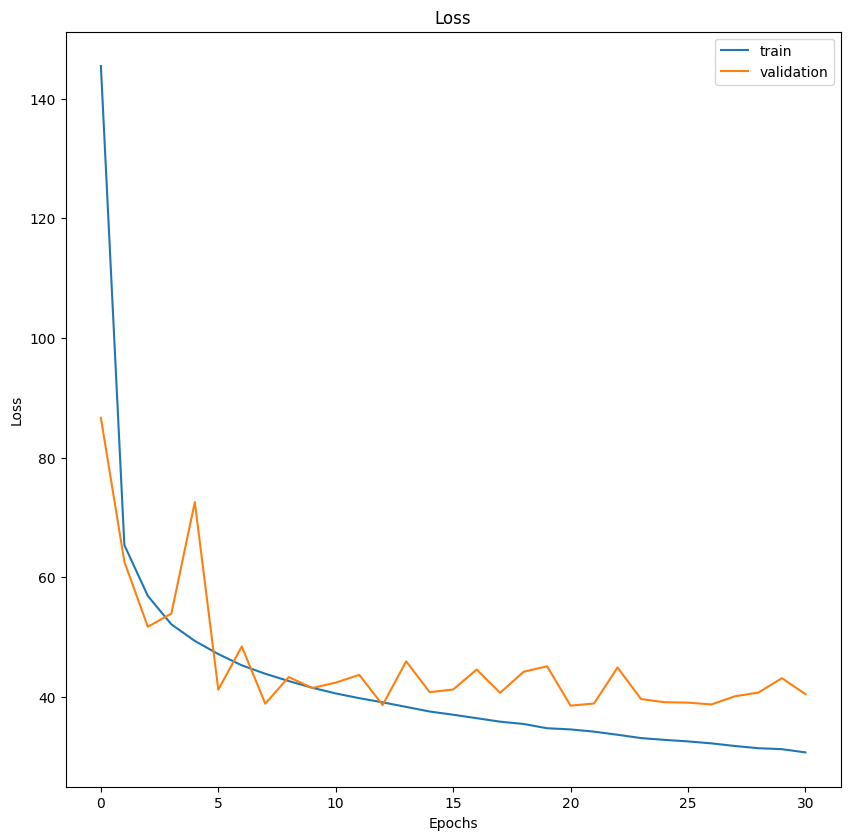

In [0]:
print(f"Model loss={results}")
plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [0]:
def display_predicted_bbox(image, bbox_true, bbox_pred):
    image=image*255
    im=Image.fromarray(image.reshape(image.shape[:2]).astype('uint8'), 'L')
    rgbimg = Image.new("RGB", im.size)
    rgbimg.paste(im)
    draw = ImageDraw.Draw(rgbimg)
    draw.rectangle([bbox_true[0], bbox_true[1], bbox_true[0]+bbox_true[3], bbox_true[1]+bbox_true[2]], outline="green")
    draw.rectangle([bbox_pred[0], bbox_pred[1], bbox_pred[0]+bbox_pred[3], bbox_pred[1]+bbox_pred[2]], outline="red")
    rgbimg=rgbimg.resize((150, 150))
    return rgbimg

In [0]:
test_iter.reset()
gen_1, gen_2 = tee(test_iter)
y_true = np.vstack(tuple(next(gen_1)[1] for _ in range(len(test_iter))))
y_pred = model_4.predict(gen_2, steps=len(test_iter))

In [0]:
test_iter.reset()
all_images=np.vstack(tuple(next(test_iter)[0] for _ in range(48)))

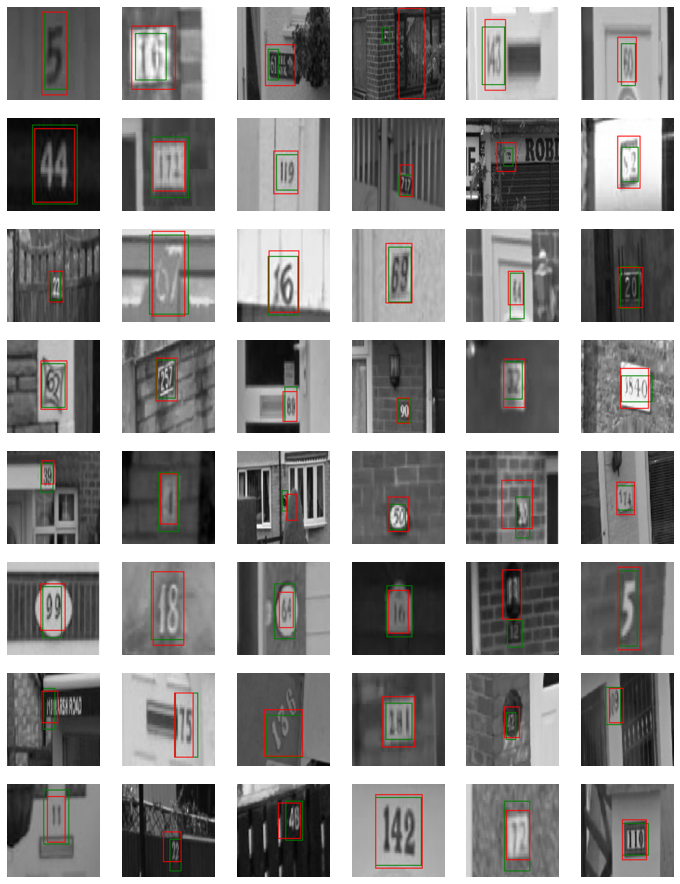

In [0]:
fig, axes = plt.subplots(8, 6, figsize=(12, 16))
for i, ax in enumerate(axes.flat): 
    ax.imshow(display_predicted_bbox(all_images[i], y_true[i], y_pred[i]))
    ax.axis("off")

In [0]:
rmtree(f'{SVHN_IMAGES_PATH}/preprocessed')